In [1]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.cluster import hierarchy
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
plt.rcParams['axes.linewidth'] = 3
plt.rc("font", family="Bookman Old Style", weight="bold")
get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
def evaluate_features(X, y):
    number_of_features = list(range(1, len(X.columns)))
    anova_svm = Pipeline(
        steps=[("ANOVA", SelectKBest(
            score_func=f_classif)),
            ("Scaler", StandardScaler()),
            ("SVC", SVC())],
        verbose=False)
    score_means = list()
    score_stds = list()
    for k in number_of_features:
        anova_svm.set_params(ANOVA__k=k)
        this_scores = cross_val_score(anova_svm, X, y,
                                      scoring="f1_macro", cv=4)
        score_means.append(this_scores.mean() * 100)
        score_stds.append(this_scores.std() * 100)
    return score_means, score_stds, number_of_features


def select_features(X, y, k):
    anova_svm = Pipeline(
        steps=[("ANOVA",
                SelectKBest(score_func=f_classif, k=k)),
               ("Scaler", StandardScaler()),
               ("SVC", SVC())],
        verbose=False)
    anova_svm.fit(X, y)
    selected_features = list()
    for selected, feature in zip(
            anova_svm.get_params()["ANOVA"].get_support(),
            X.columns):
        if selected:
            selected_features.append(feature)
    return selected_features, anova_svm.get_params()["ANOVA"].scores_

In [3]:
data = pd.read_csv("enose_dataset\\data.csv", header=0, index_col=0)
X_MOS = data.iloc[:, 0:56]
X_CSA = data.iloc[:, 56:80]
X_FUSION = data.iloc[:, :80]
y = data["VOC"]

In [4]:
def plot_f1score_evolution_over_nfeatures(X, y, title):
    score_means, score_stds, number_of_features = evaluate_features(X, y)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), dpi=300)
    ax.errorbar(
        number_of_features, score_means,
        score_stds, ecolor="black")
    ax.grid(which="major", color="black", linestyle="--", alpha=0.3)
    ax.set_ylim([0, 105])
    ax.set_xlim([number_of_features[0], number_of_features[-1]])
    ax.set_ylabel("F1-score (%)", fontsize=15, fontweight="bold")
    ax.set_yticks(list(range(0, 110, 10)))
    ax.set_xlabel("Number of Features", fontsize=15, fontweight="bold")
    ax.set_xticks(list(range(1, np.max(number_of_features)+1, 4)))
    ax.set_title(title, fontsize=20, fontweight="bold", pad=18)
    fig.tight_layout()
    return ax

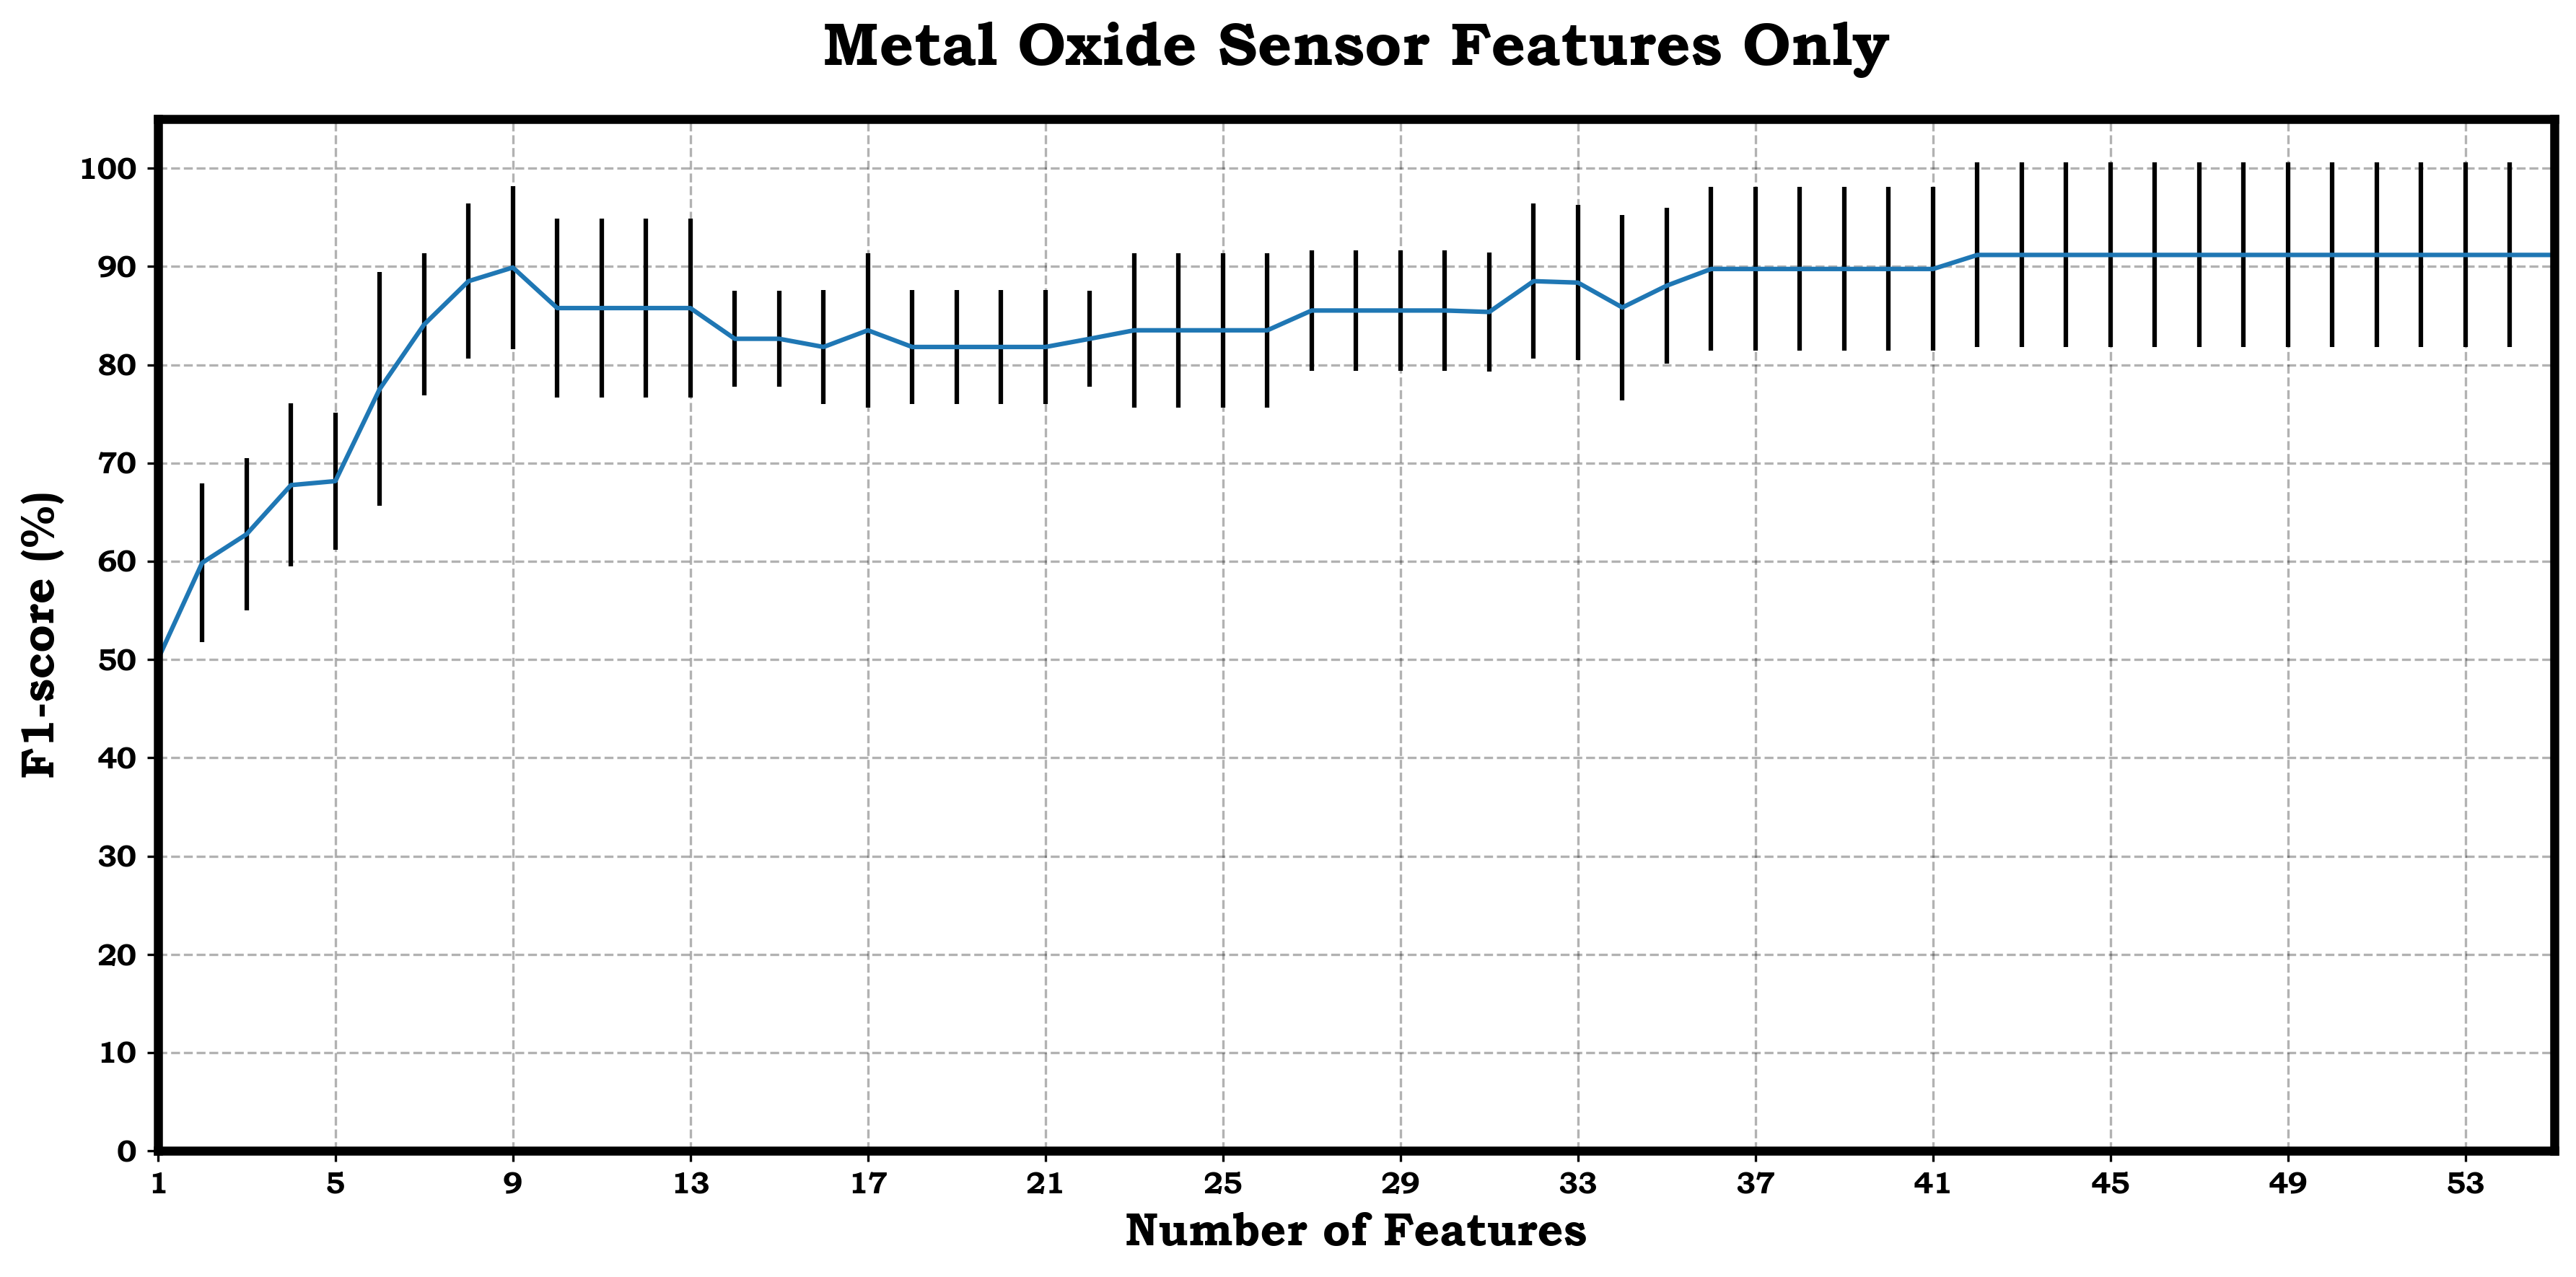

In [5]:
ax = plot_f1score_evolution_over_nfeatures(
    X_MOS, y, "Metal Oxide Sensor Features Only")

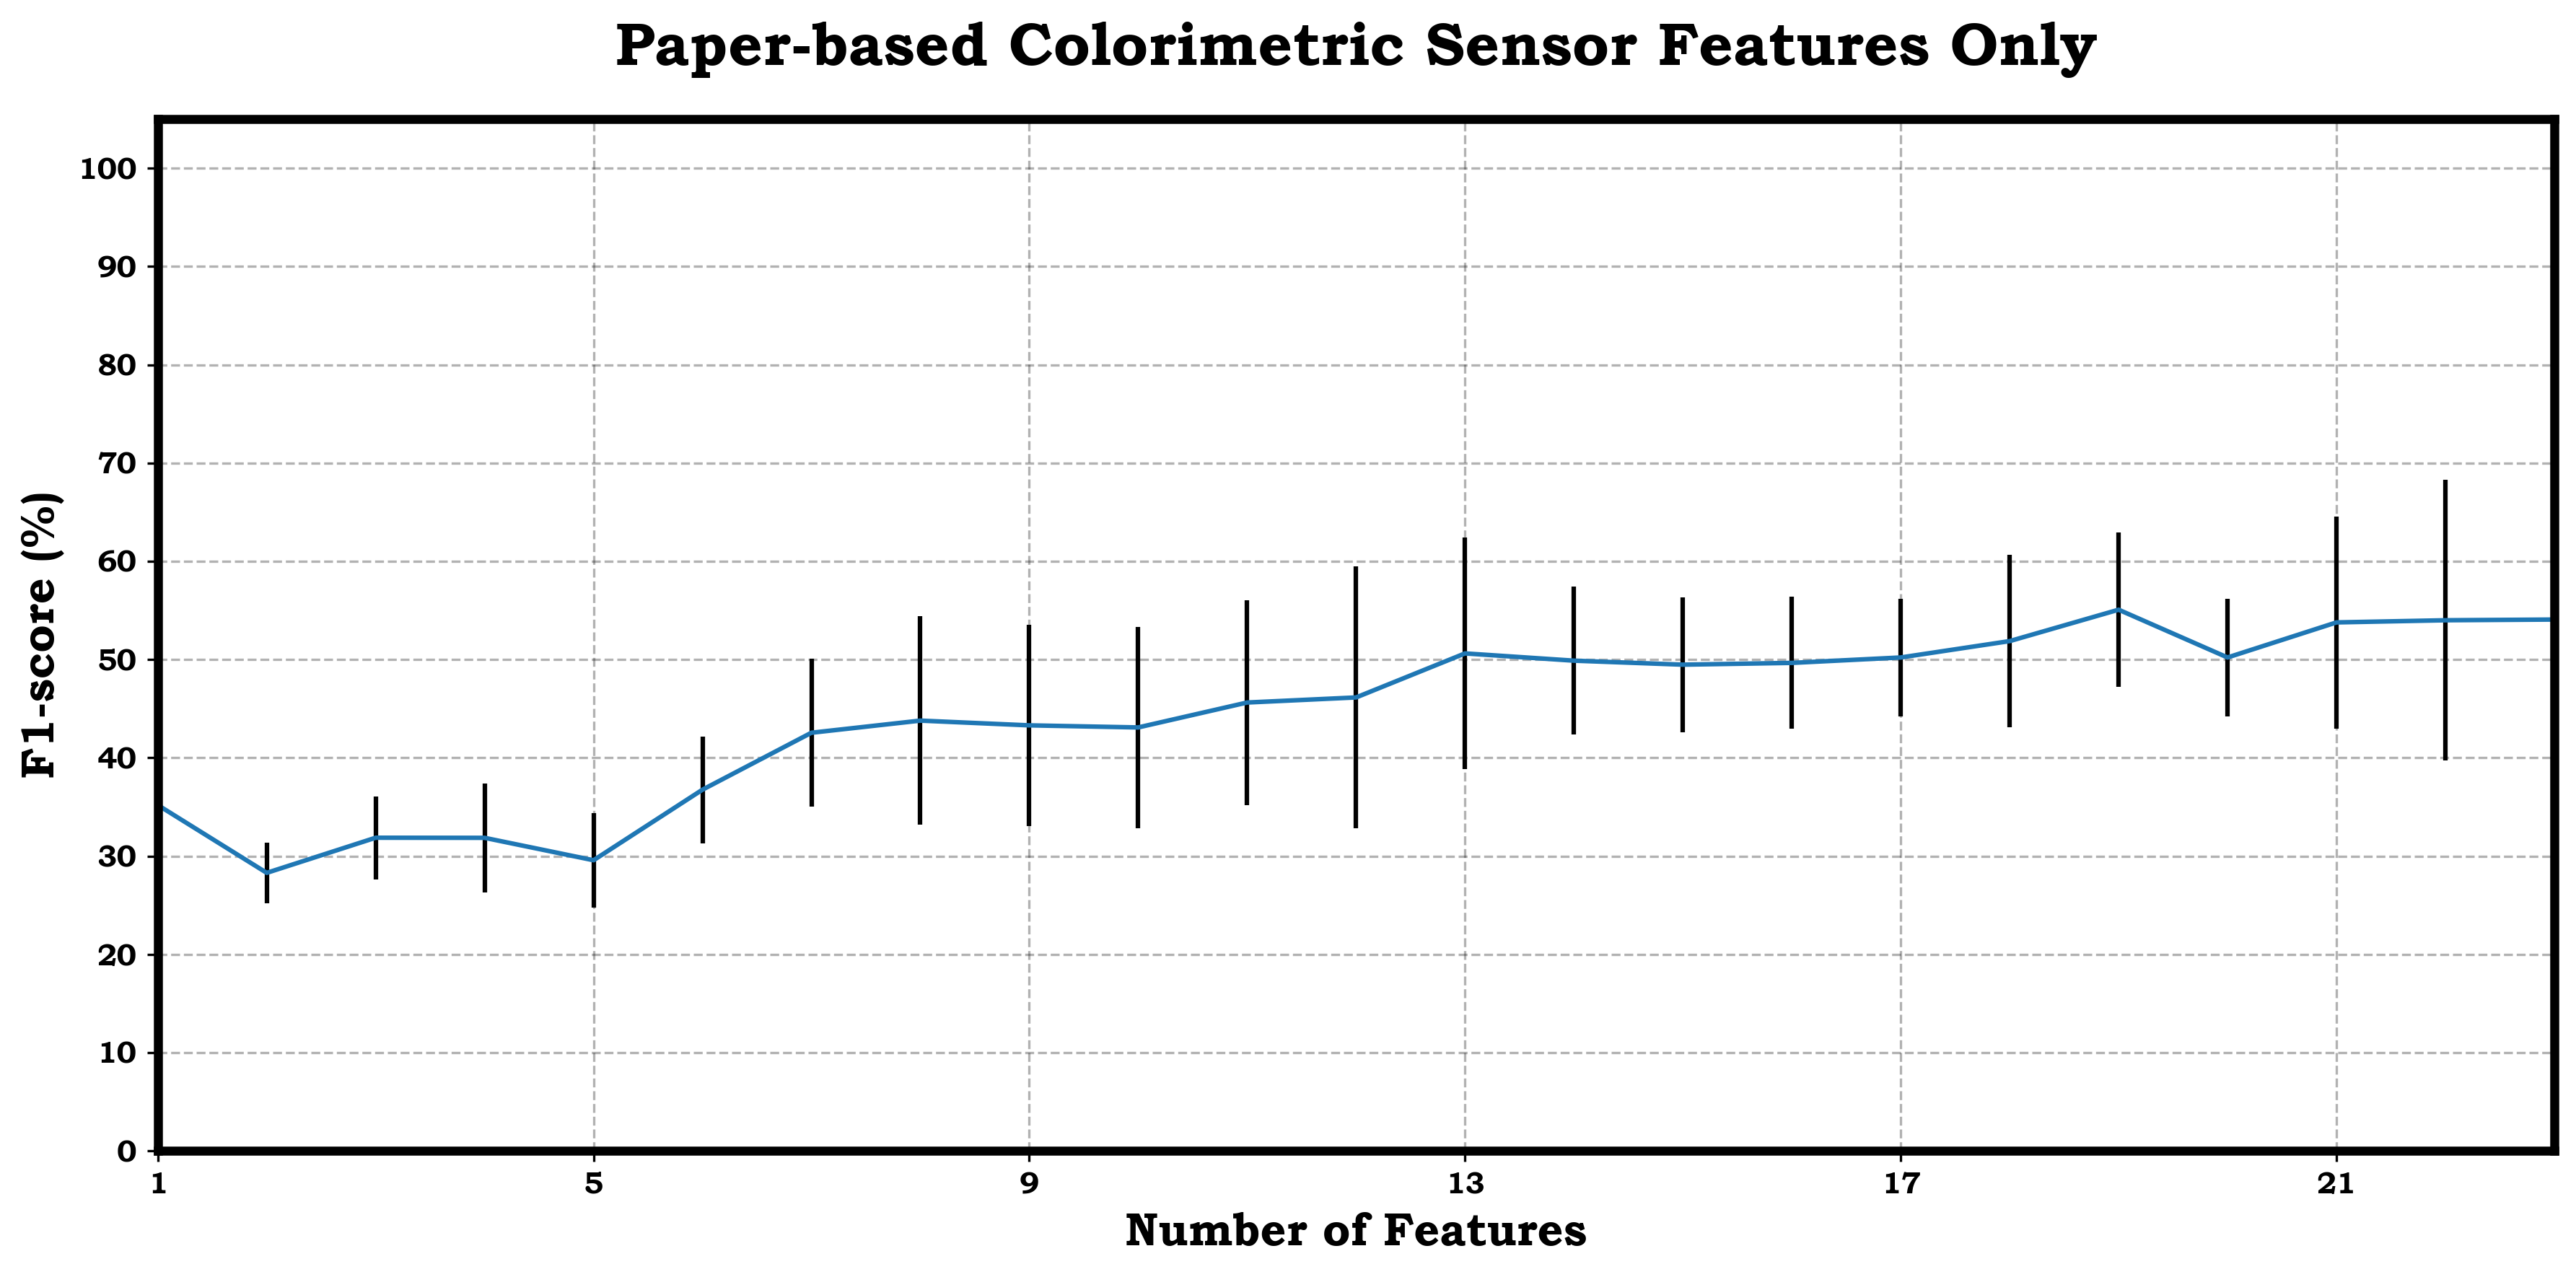

In [6]:
ax = plot_f1score_evolution_over_nfeatures(
    X_CSA, y,
    "Paper-based Colorimetric Sensor Features Only")

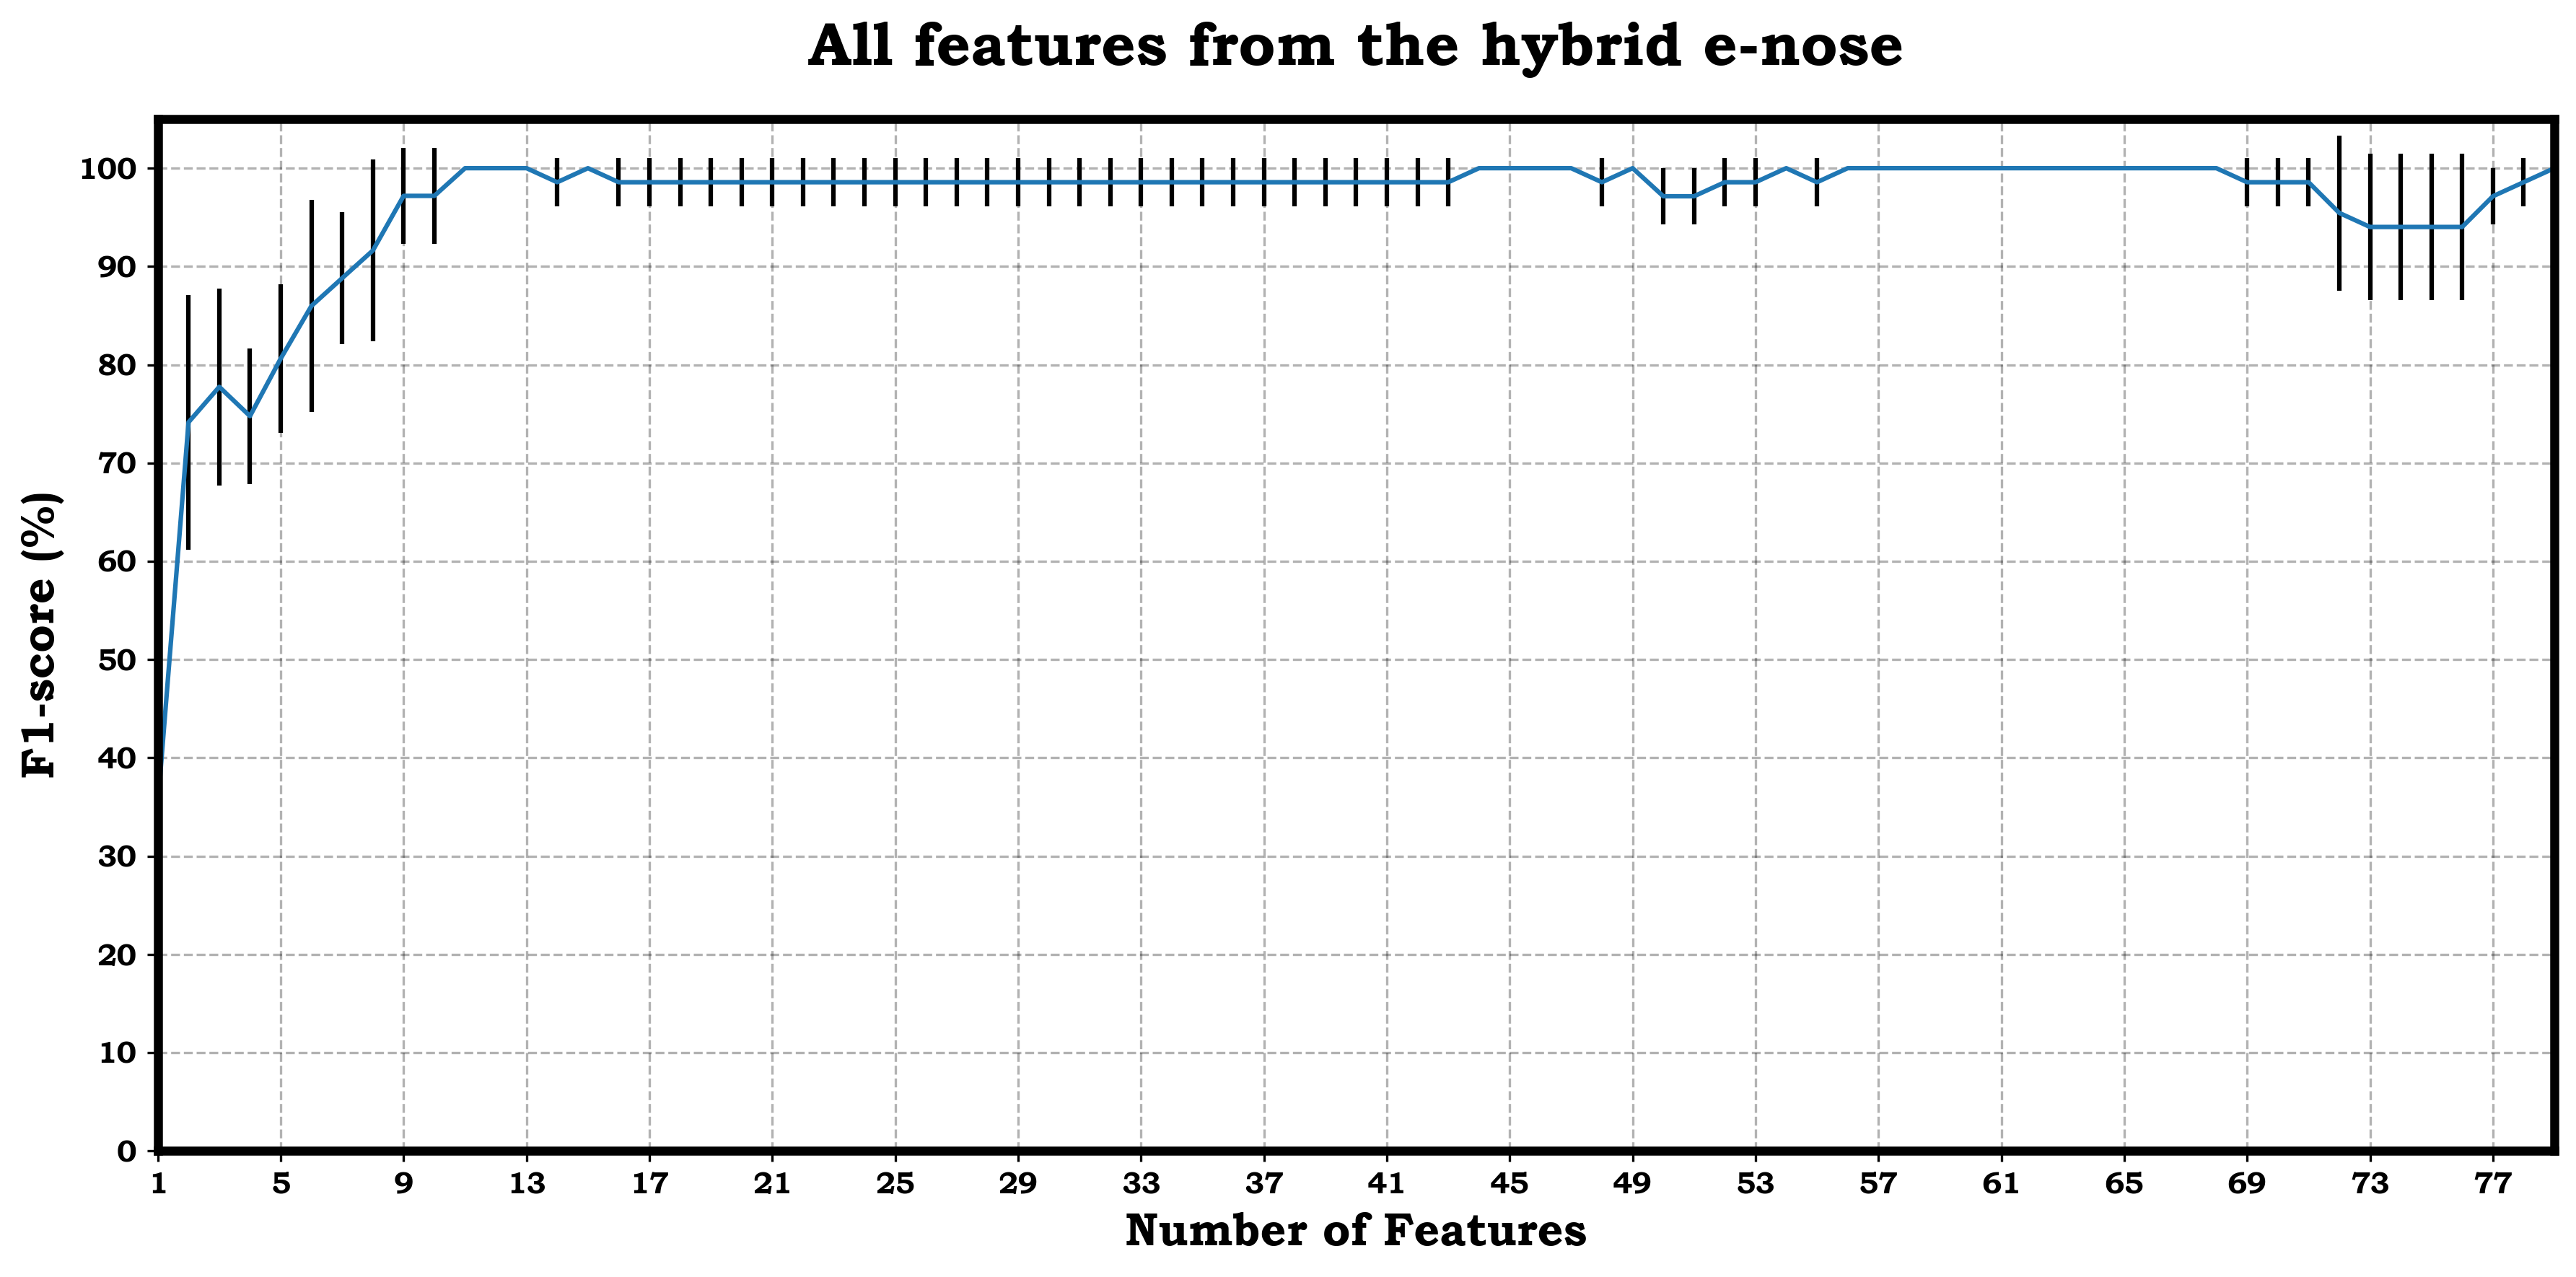

In [7]:
ax = plot_f1score_evolution_over_nfeatures(
    X_FUSION, y,
    "All features from the hybrid e-nose")

In [8]:
def pca_and_var(X=None, n_components=10):
    principal_component_labels = [
        "PC" + str(i+1) for i in range(n_components)]
    pca_pipeline = Pipeline(
        steps=[("Scaler", StandardScaler()),
               ("PCA", PCA(n_components))],
        verbose=False)
    pca_X = pca_pipeline.fit_transform(X)
    pca_X = pd.DataFrame(data=pca_X,
                         columns=principal_component_labels)
    explained_var_ratio = pca_pipeline.get_params()[
        "PCA"].explained_variance_ratio_
    explained_var = list(map(lambda ratio: round(
        ratio * 100, 2), explained_var_ratio))
    explained_var = pd.Series(
        data=explained_var, index=principal_component_labels)
    return pca_X, explained_var

In [9]:
def scree_plot(X=None, n_components=None, title=None):
    fig, ax = plt.subplots(nrows=1, ncols=1,
                           figsize=(12, 6), dpi=300)
    explained_variance = pca_and_var(X, n_components)[1]
    explained_variance.plot(ax=ax,
                            kind="bar",
                            rot=0)
    ax.set_ylabel("Explained Variance (%)", fontsize=15,
                  fontweight="bold")
    ax.set_xlabel("Principal Components (PC)", fontsize=15,
                  fontweight="bold")
    ax.set_title(title, fontsize=18, fontweight="bold", pad=20)
    fig.tight_layout()

In [10]:
def pairwise_pca_plots(X=None, y=None, title=None,
                       ylim=None, xlim=None):
    fig, axs = plt.subplots(nrows=2, ncols=3,
                            figsize=(12, 6), dpi=300)
    pairs = combinations(["PC" + str(i+1) for i in range(4)], 2)
    pca_data, exp_var = pca_and_var(X, n_components=4)
    handle, labels = None, None
    for ax, pair in zip(axs.flat, pairs):
        sns.scatterplot(ax=ax,
                        data=pca_data,
                        x=pair[0],
                        y=pair[1],
                        hue=y,)
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()
        ax.set_xlabel(pair[0] + f"({exp_var[pair[0]]}%)",
                      fontsize=12, fontweight="bold")
        ax.set_ylabel(pair[1] + f"({exp_var[pair[1]]}%)",
                      fontsize=12, fontweight="bold")
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
    fig.legend(handles, labels, loc="upper center",
               bbox_to_anchor=(0.0, 0.6, 1, 0.5), ncol=6, fontsize=15)
    fig.tight_layout(h_pad=3)

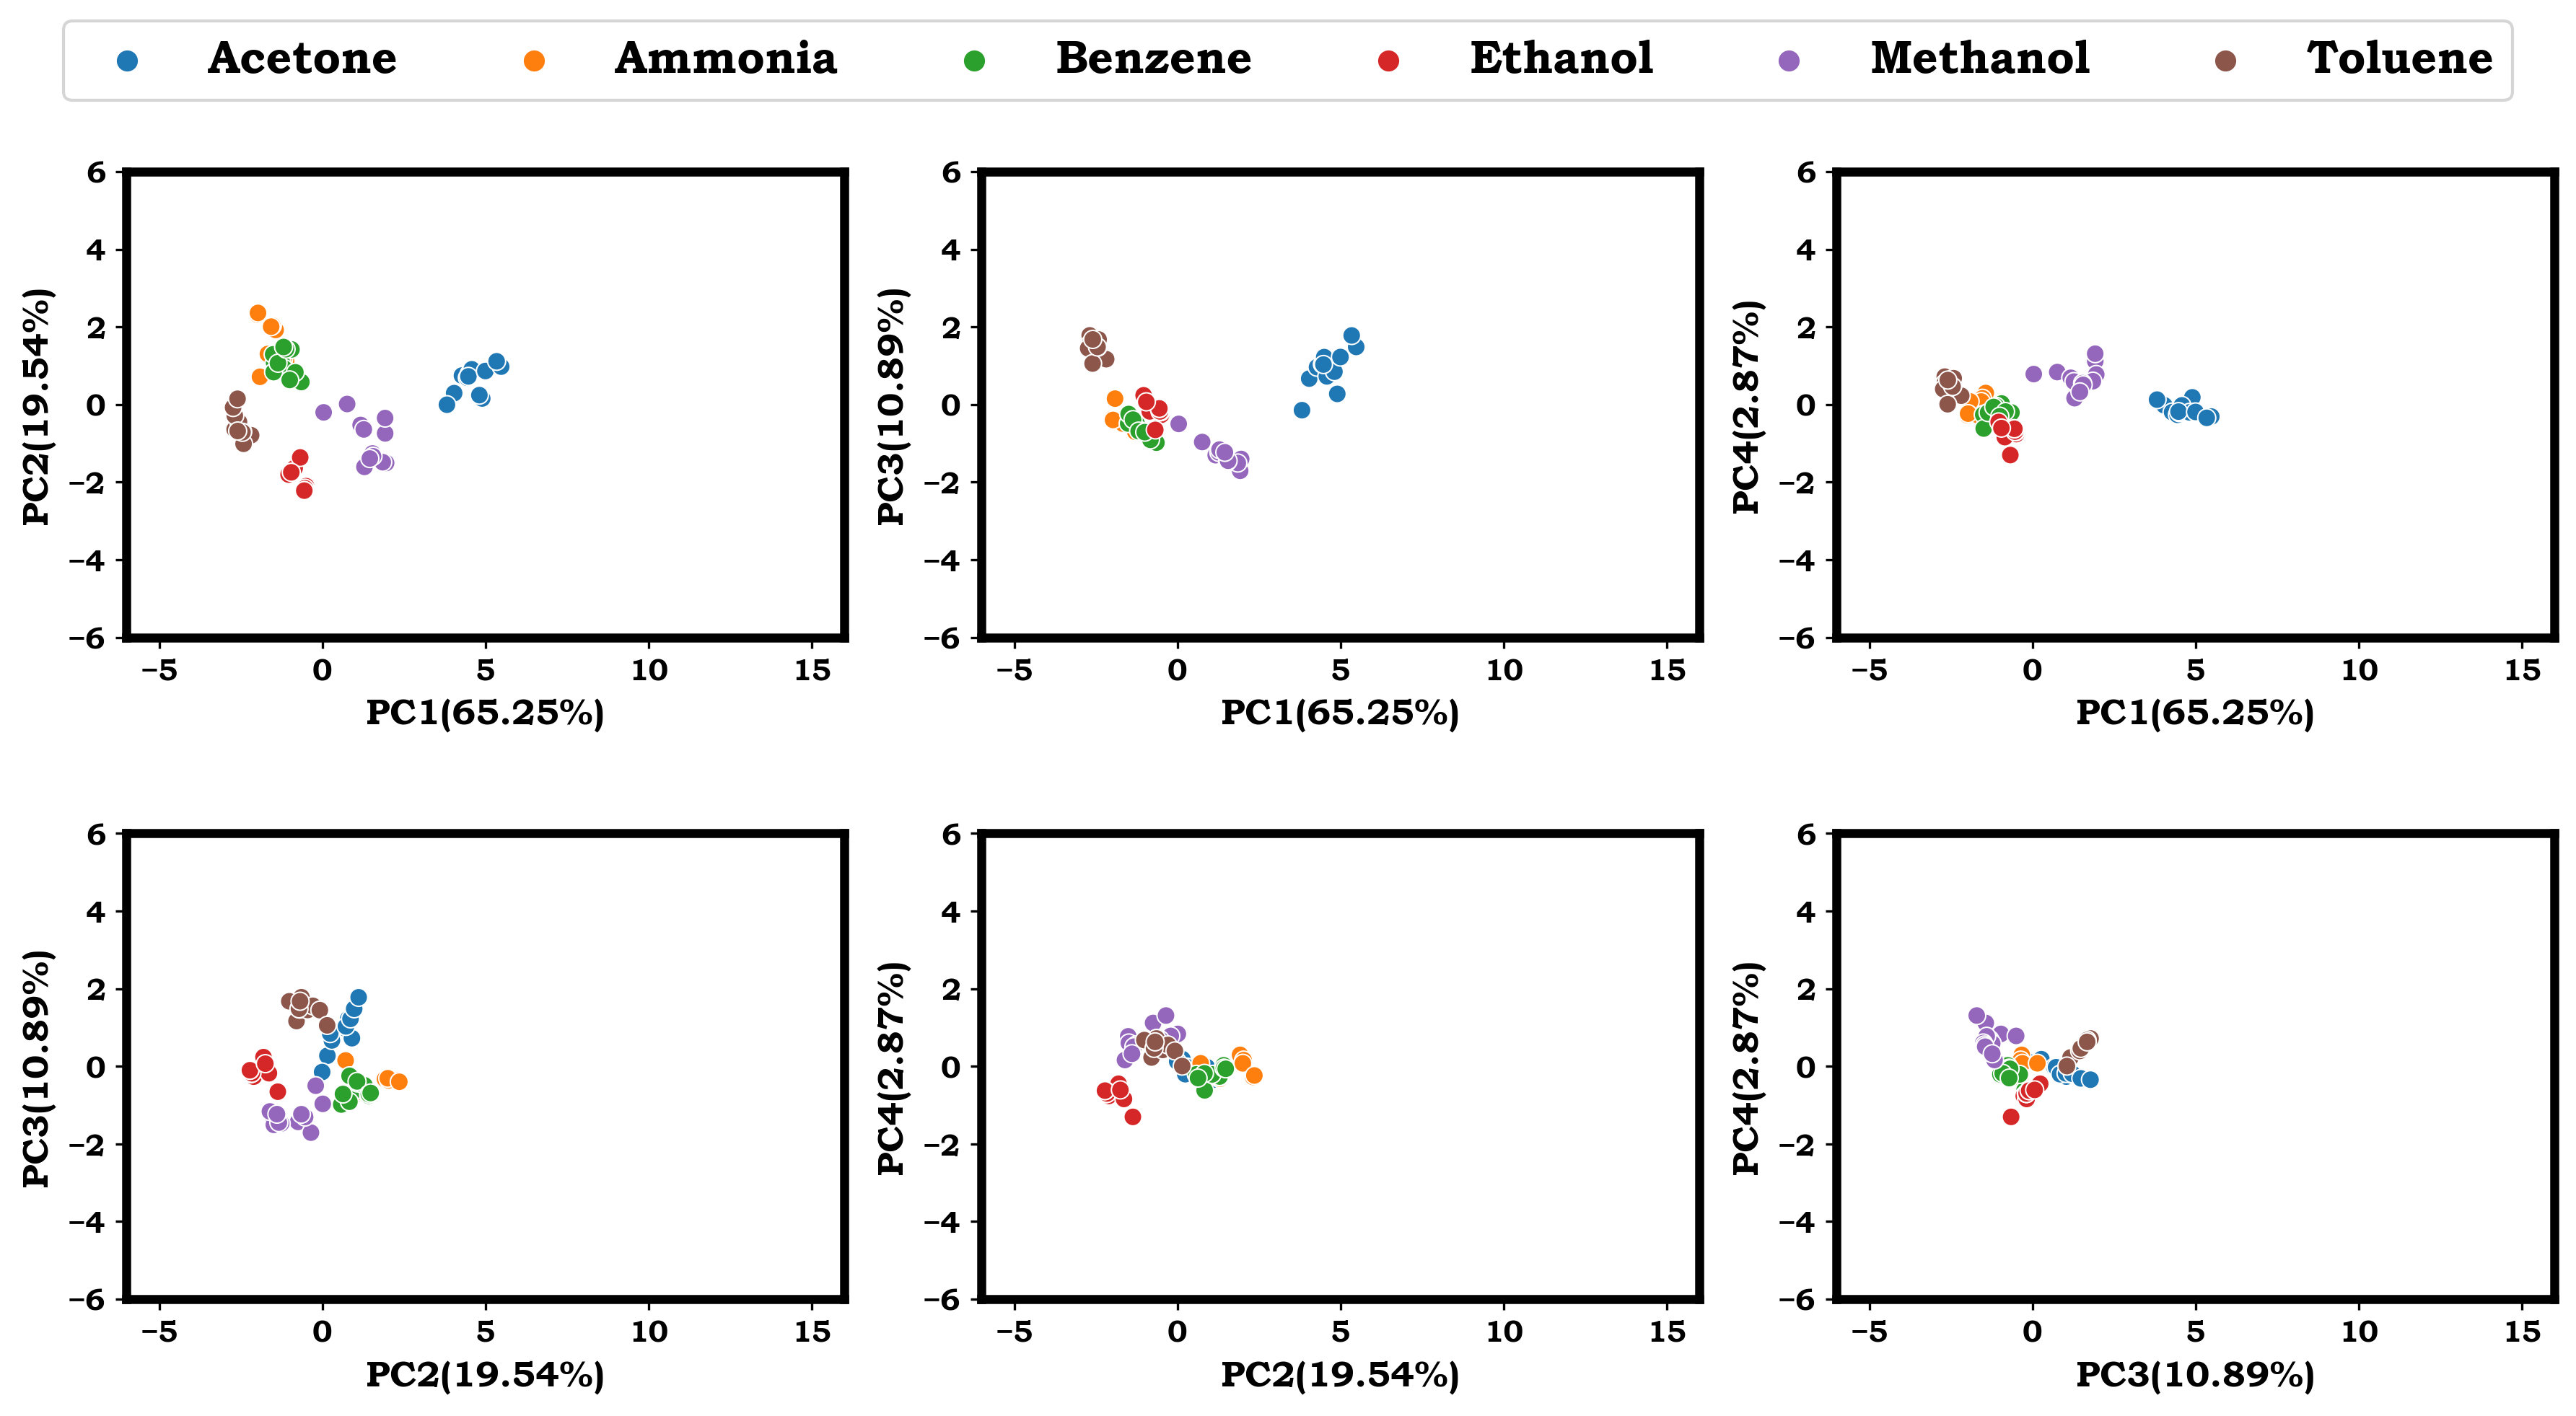

In [11]:
MOS_selected_features, MOS_features_scores = select_features(
    X=X_MOS, y=y, k=9)
X_MOS_selected = X_MOS[MOS_selected_features]
pairwise_pca_plots(X=X_MOS_selected, y=y, ylim=[-6, 6], xlim=[-6, 16])

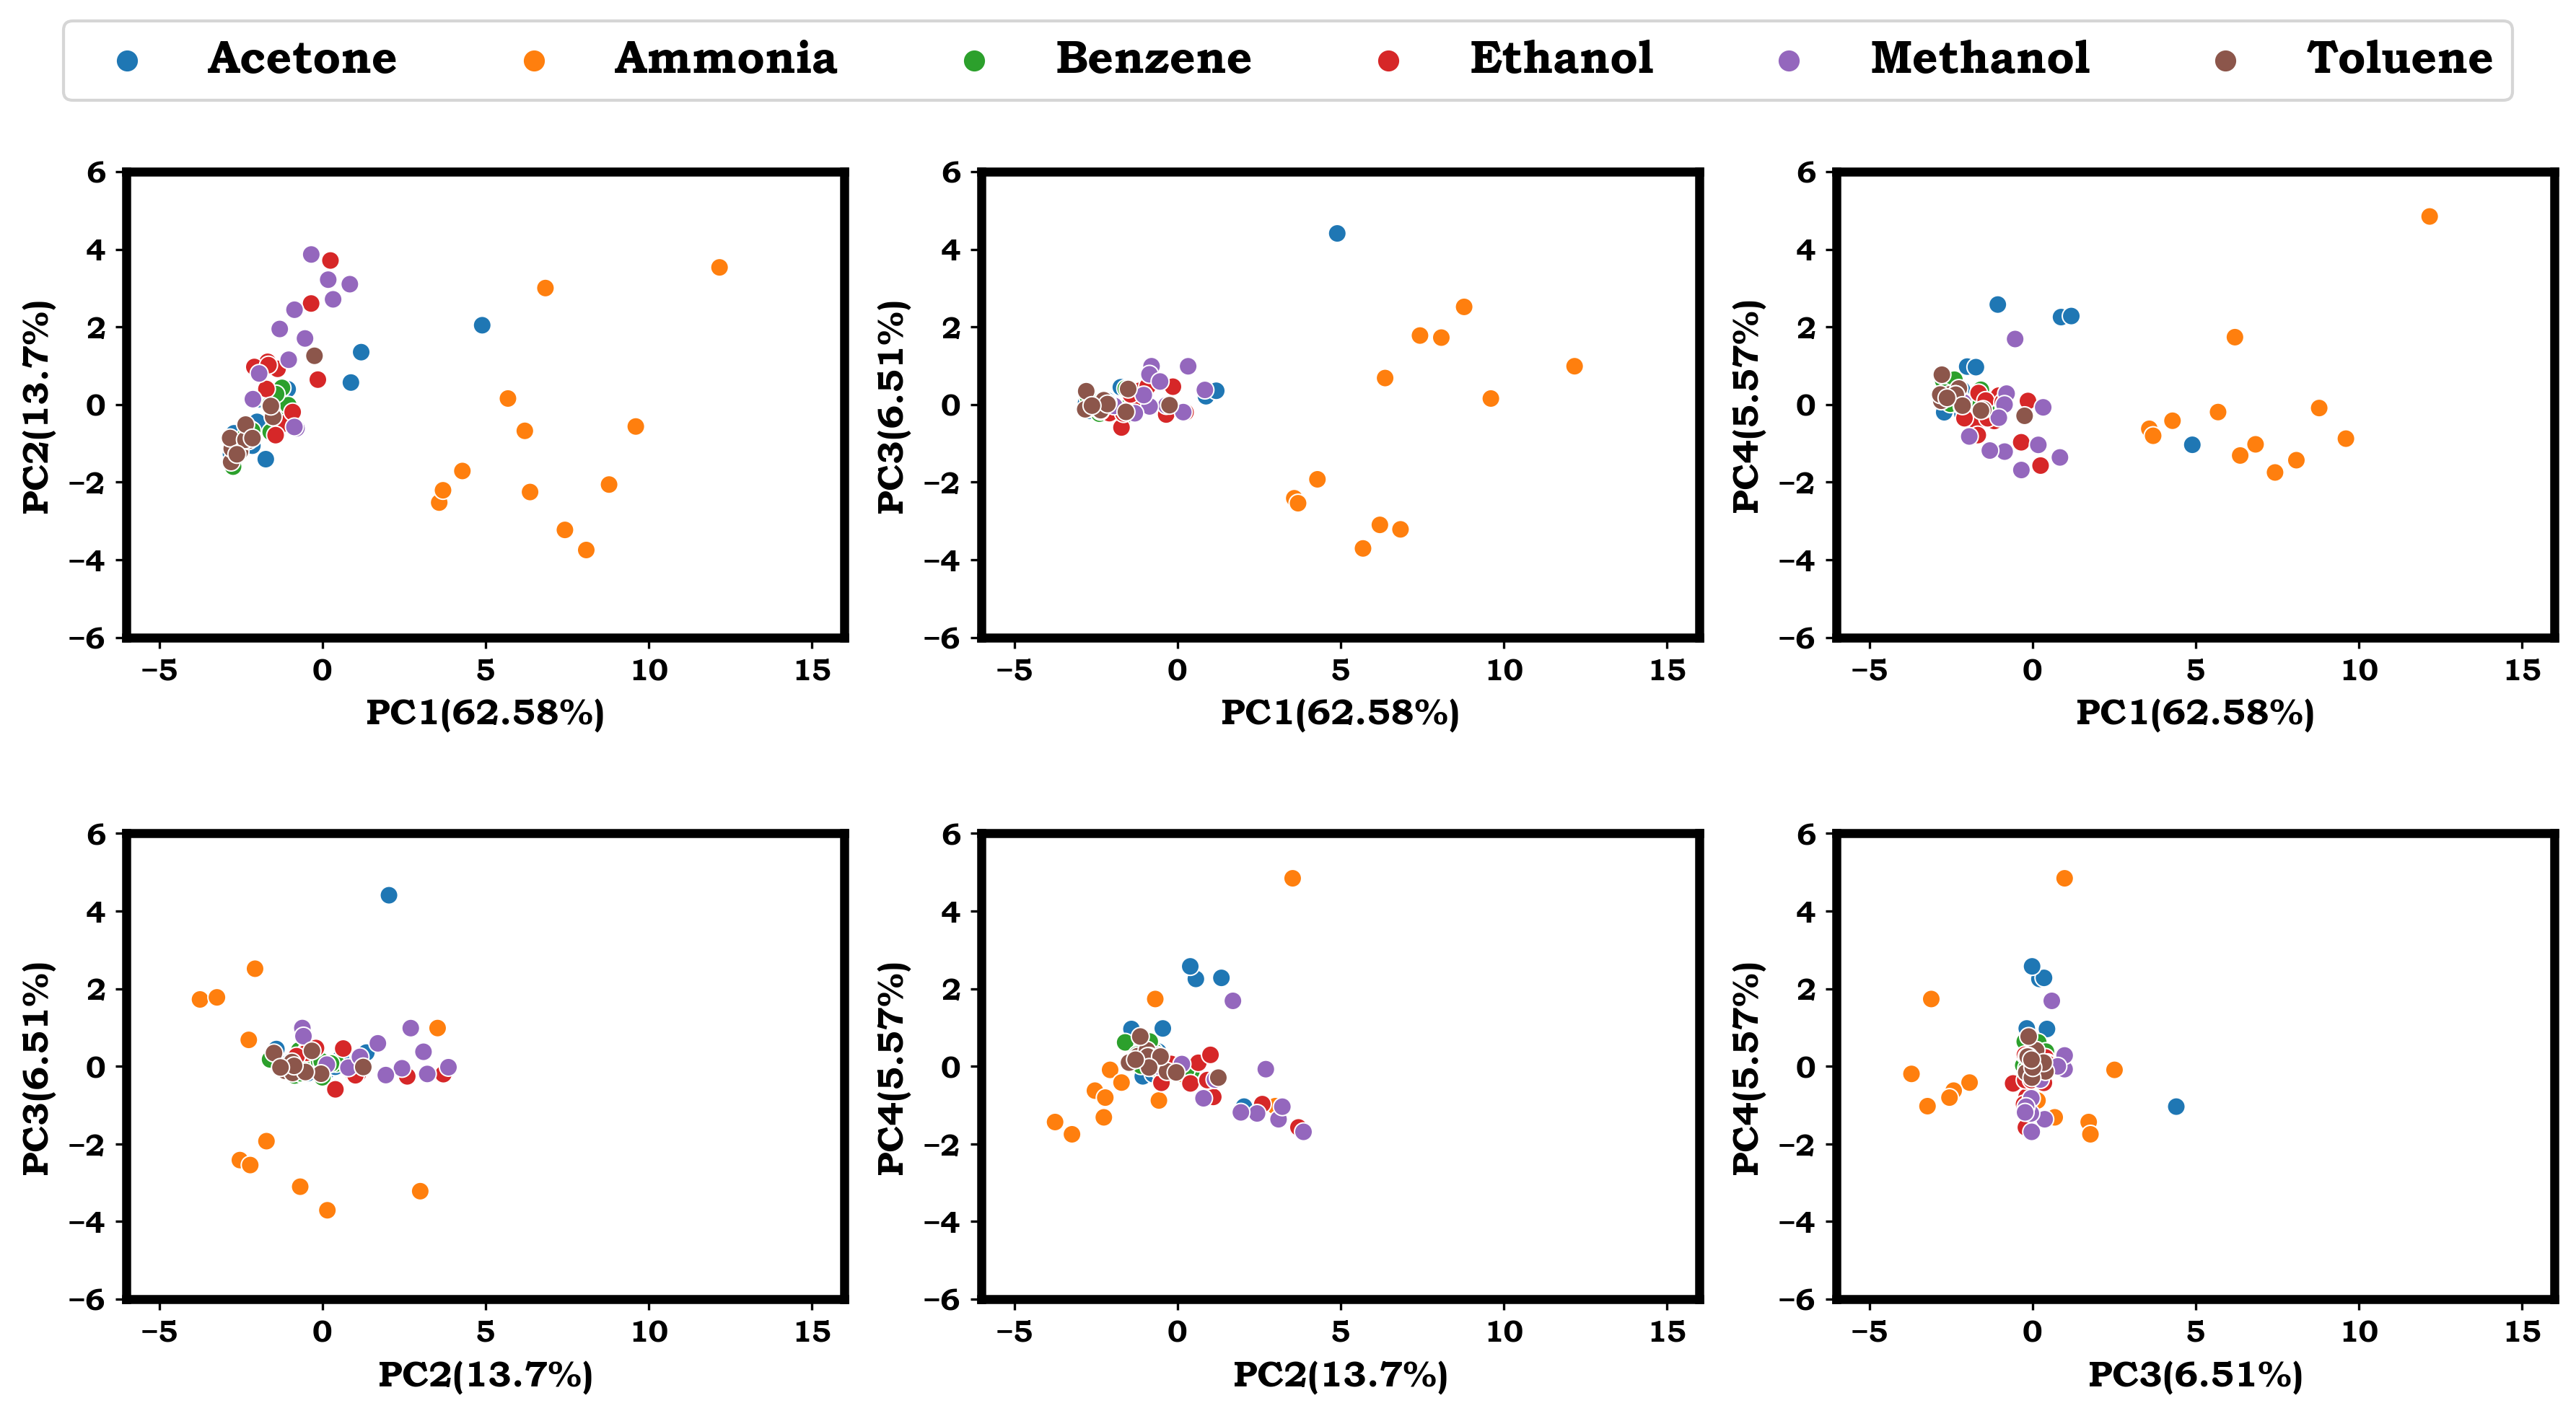

In [12]:
CSA_selected_features, CSA_features_scores = select_features(
    X=X_CSA, y=y, k=19)
X_CSA_selected = X_CSA[CSA_selected_features]
pairwise_pca_plots(X=X_CSA_selected, y=y,
                   ylim=[-6, 6], xlim=[-6, 16])

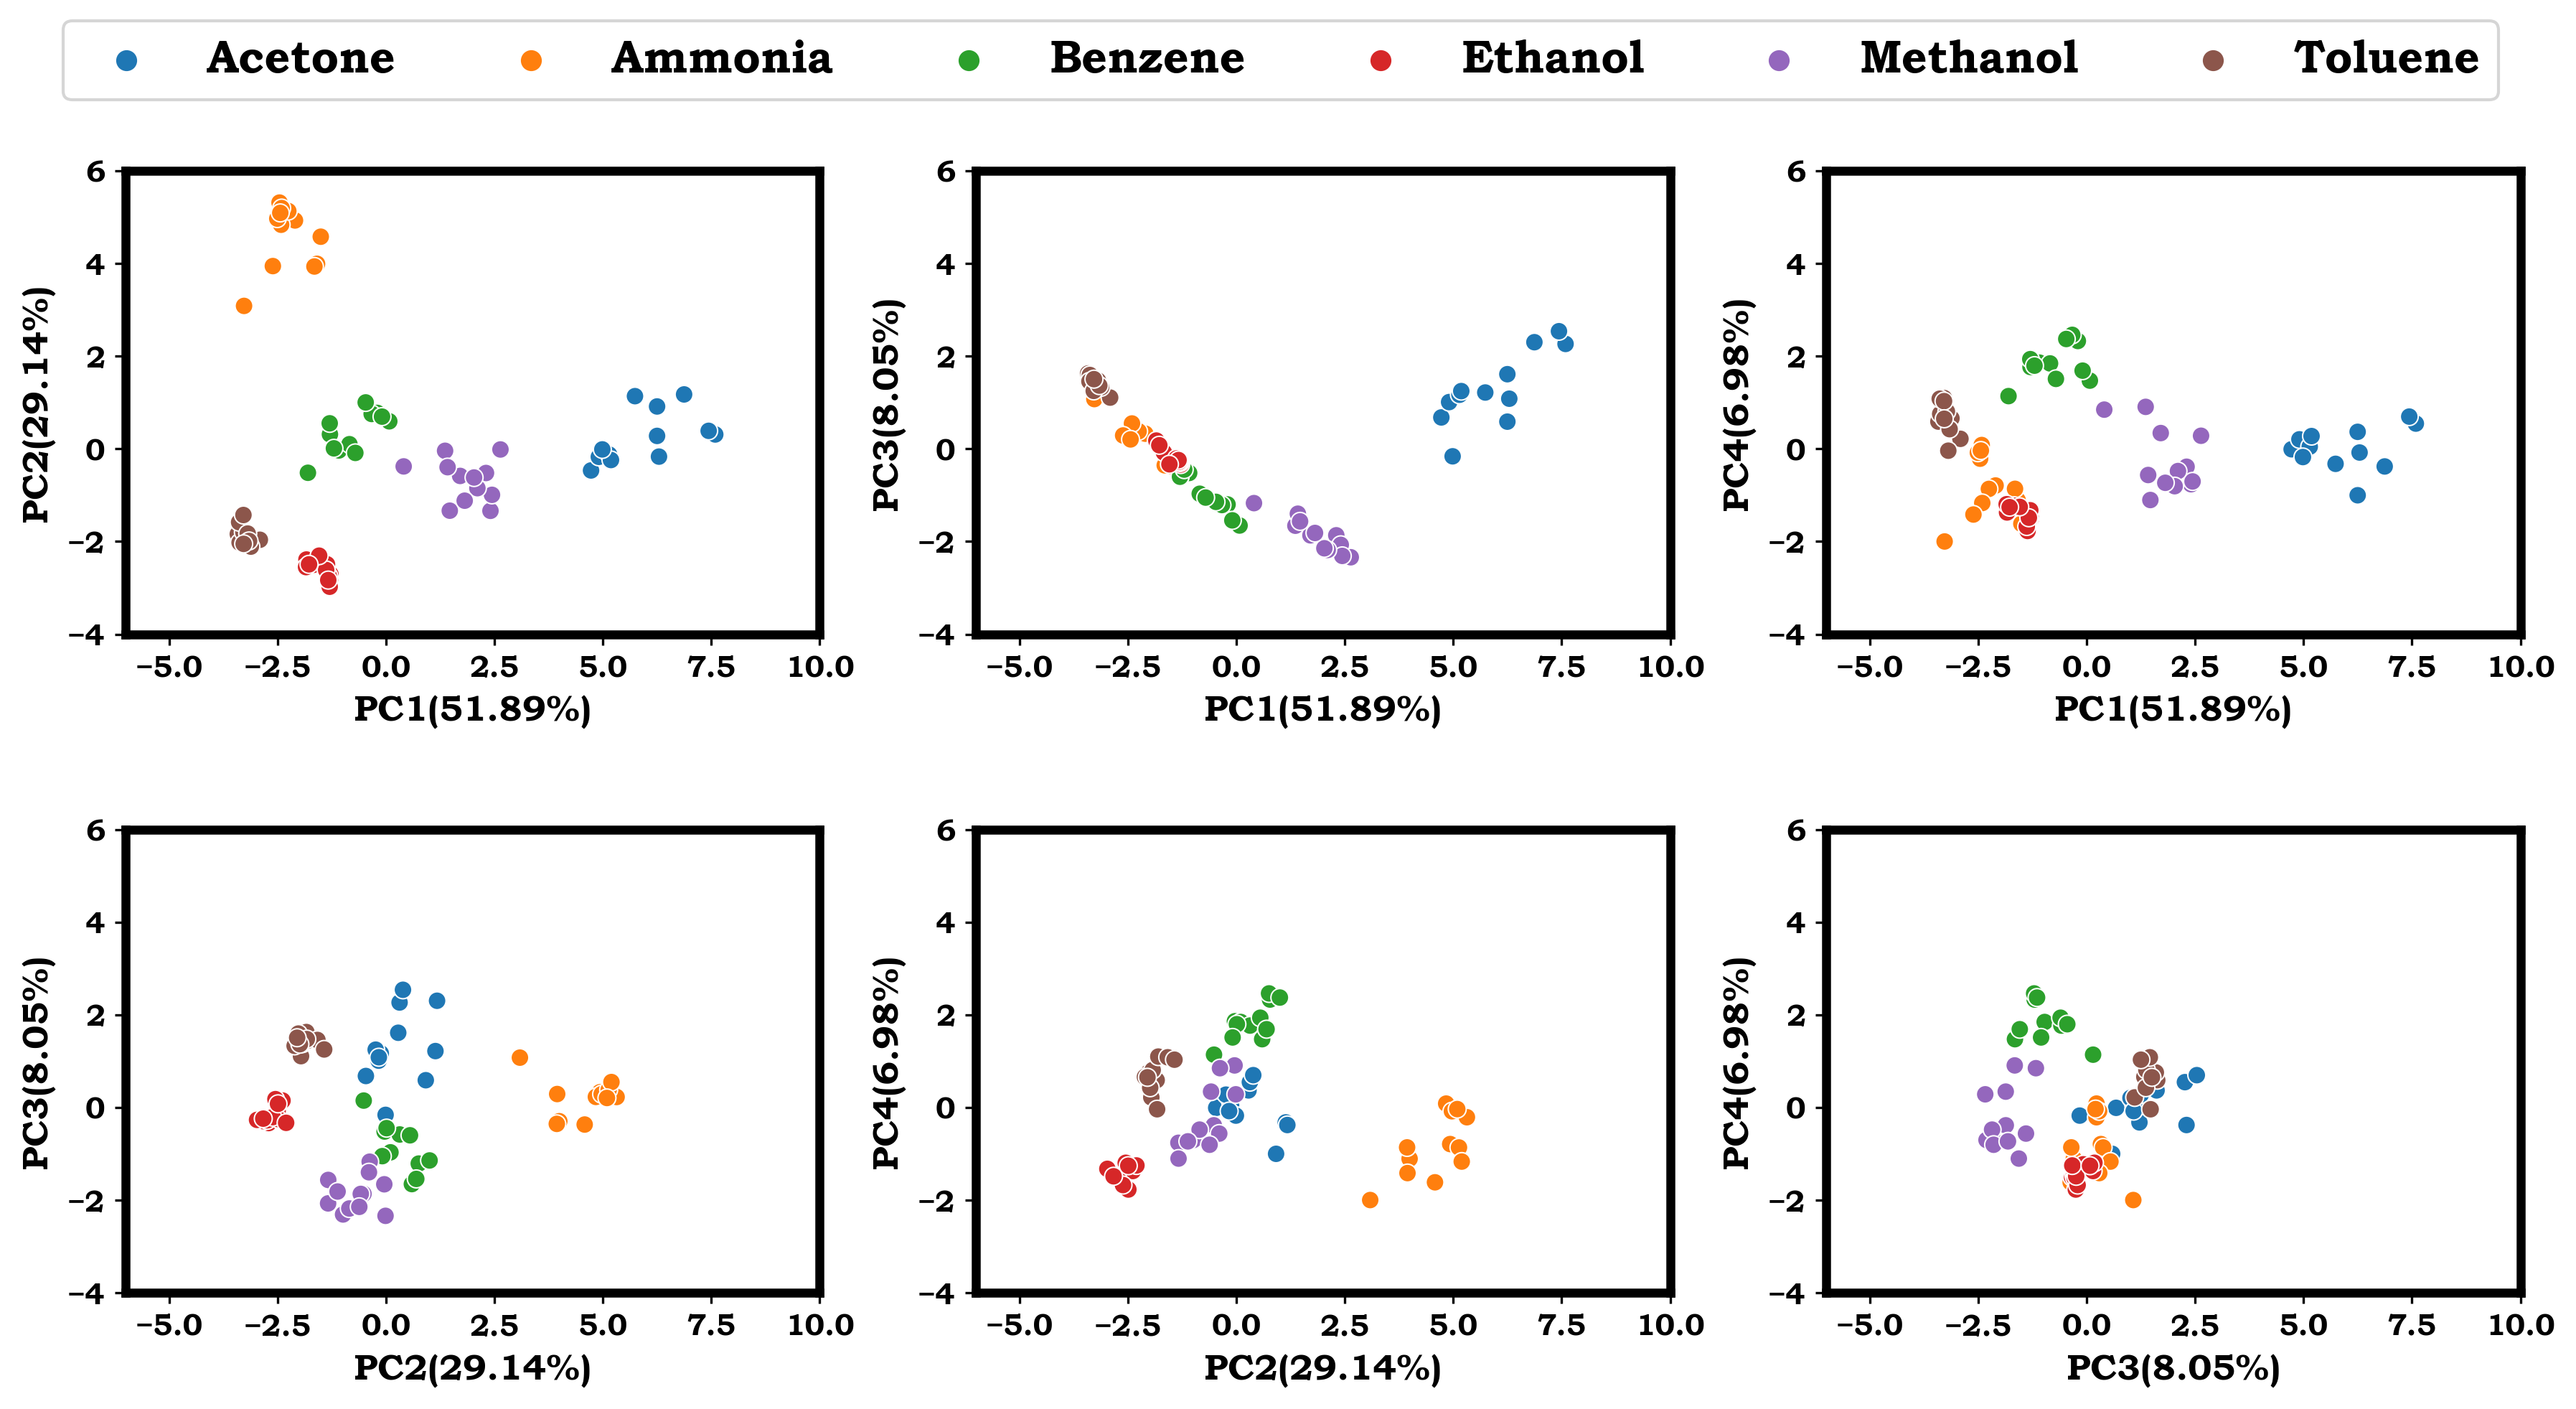

In [14]:
FUSION_selected_features, FUSION_features_scores = select_features(
    X=X_FUSION, y=y, k=19)
X_FUSION_selected = X_FUSION[FUSION_selected_features]
pairwise_pca_plots(X=X_FUSION_selected,
                   y=y, ylim=[-4, 6], xlim=[-6, 10])

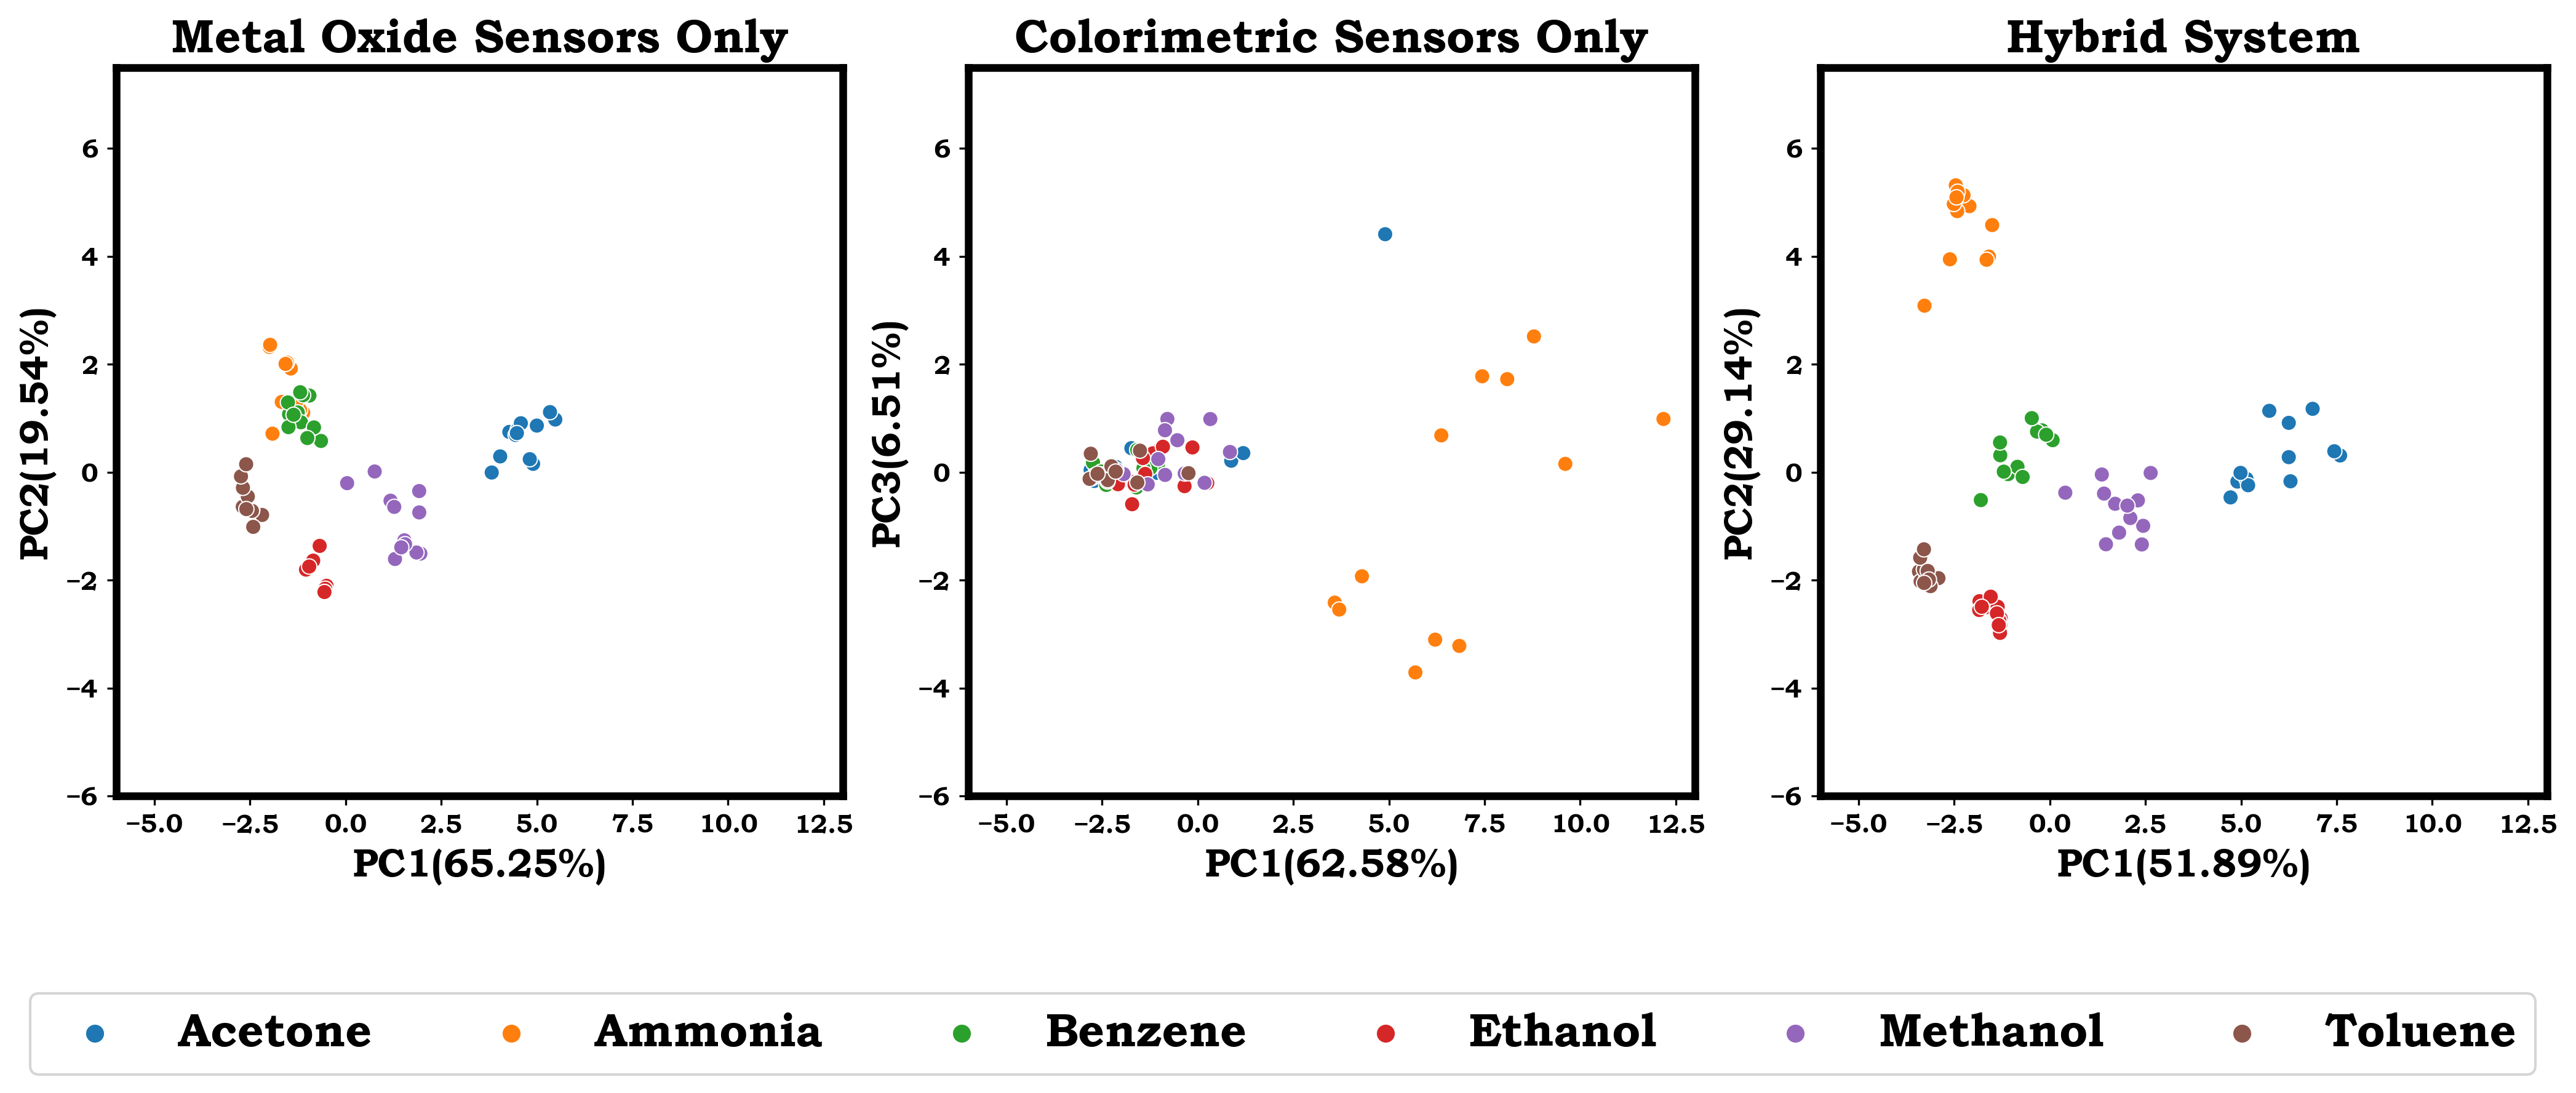

In [15]:
hybrid_pca, hybrid_exp = pca_and_var(
    X_FUSION[FUSION_selected_features], n_components=4)
MOS_pca, MOS_exp = pca_and_var(X_MOS[MOS_selected_features],
                               n_components=4)
CSA_pca, CSA_exp = pca_and_var(X_CSA[CSA_selected_features], n_components=4)

figure, axs = plt.subplots(nrows=1, ncols=3,
                           figsize=(14, 5), dpi=300)
for ax, pair, pca, exp, title in zip(
    axs.flat,
    [("PC1", "PC2"), ("PC1", "PC3"),
     ("PC1", "PC2")],
    [MOS_pca, CSA_pca, hybrid_pca],
    [MOS_exp, CSA_exp, hybrid_exp],
    ["Metal Oxide Sensors Only",
     "Colorimetric Sensors Only",
     "Hybrid System"]):
    sns.scatterplot(ax=ax,
                    data=pca,
                    x=pair[0],
                    y=pair[1],
                    hue=y)
    ax.set_xlabel(pair[0] + f"({exp[pair[0]]}%)",
                  fontsize=15, fontweight="bold")
    ax.set_ylabel(pair[1] + f"({exp[pair[1]]}%)",
                  fontsize=15, fontweight="bold")
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    ax.set_xlim([-6, 13])
    ax.set_ylim([-6, 7.5])
    ax.set_title(title, fontsize=18, fontweight="bold")
figure.legend(handles, labels, loc="lower center",
              bbox_to_anchor=(0.0, -0.2, 1, 0.5),
              ncol=6, fontsize=18)
figure.tight_layout(h_pad=3)

In [16]:
def hca_plot(X=None, y=None, features=None, threshold=None,
             linkage_method="single", title=None):
    fig = plt.figure(figsize=(12, 6), dpi=300)
    ax = fig.add_subplot(111)
    X.index = y
    Z = hierarchy.linkage(X[features], linkage_method)
    dn = hierarchy.dendrogram(Z,
                              ax=ax,
                              distance_sort="ascending",
                              labels=X.index,
                              color_threshold=threshold,
                              orientation="top",
                              leaf_font_size=8)
    xmin, xmax = ax.get_xlim()
#     ax.hlines(threshold, xmin=xmin, xmax=xmax,
# linestyle="--", color="red", label=f"Threshold = {threshold}")
#     ax.legend()
    ax.set_ylabel(
        "Linkage distance or euclidean distance between clusters",
        fontdict={"size": 12, "weight": "bold"})
    ax.set_title(title,
                 fontdict={"size": 18, "weight": "bold"})
    fig.tight_layout()

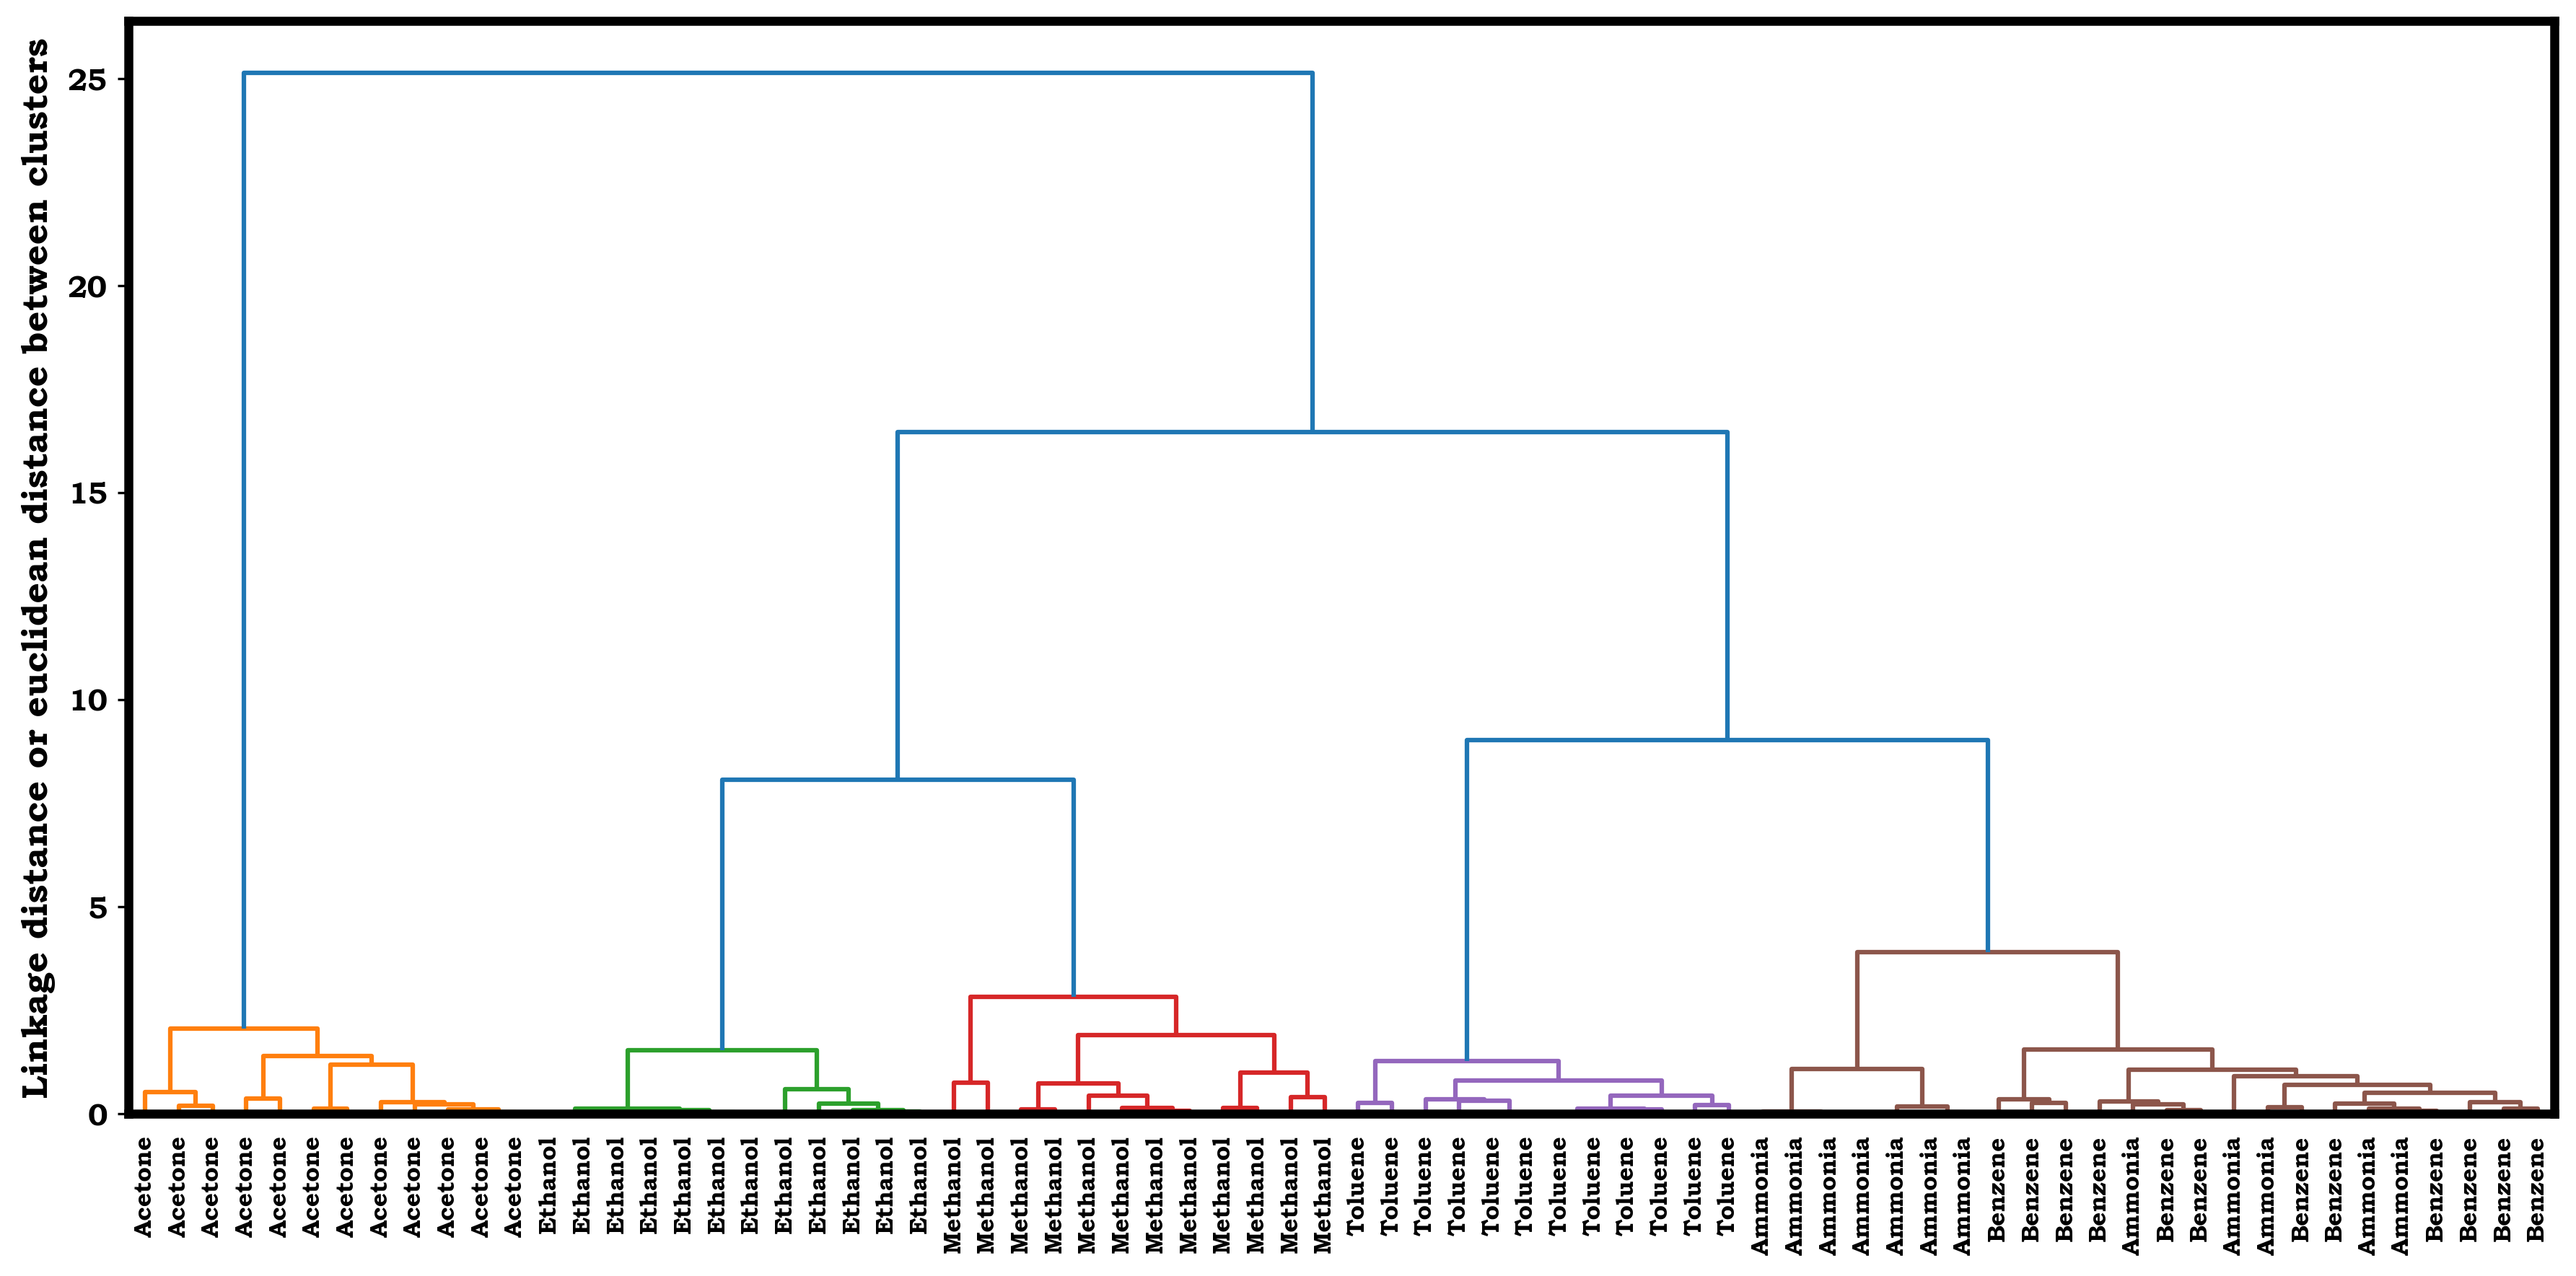

In [17]:
hca_plot(X=MOS_pca, y=y, features=[
         "PC1", "PC2"], threshold=5, linkage_method="ward")

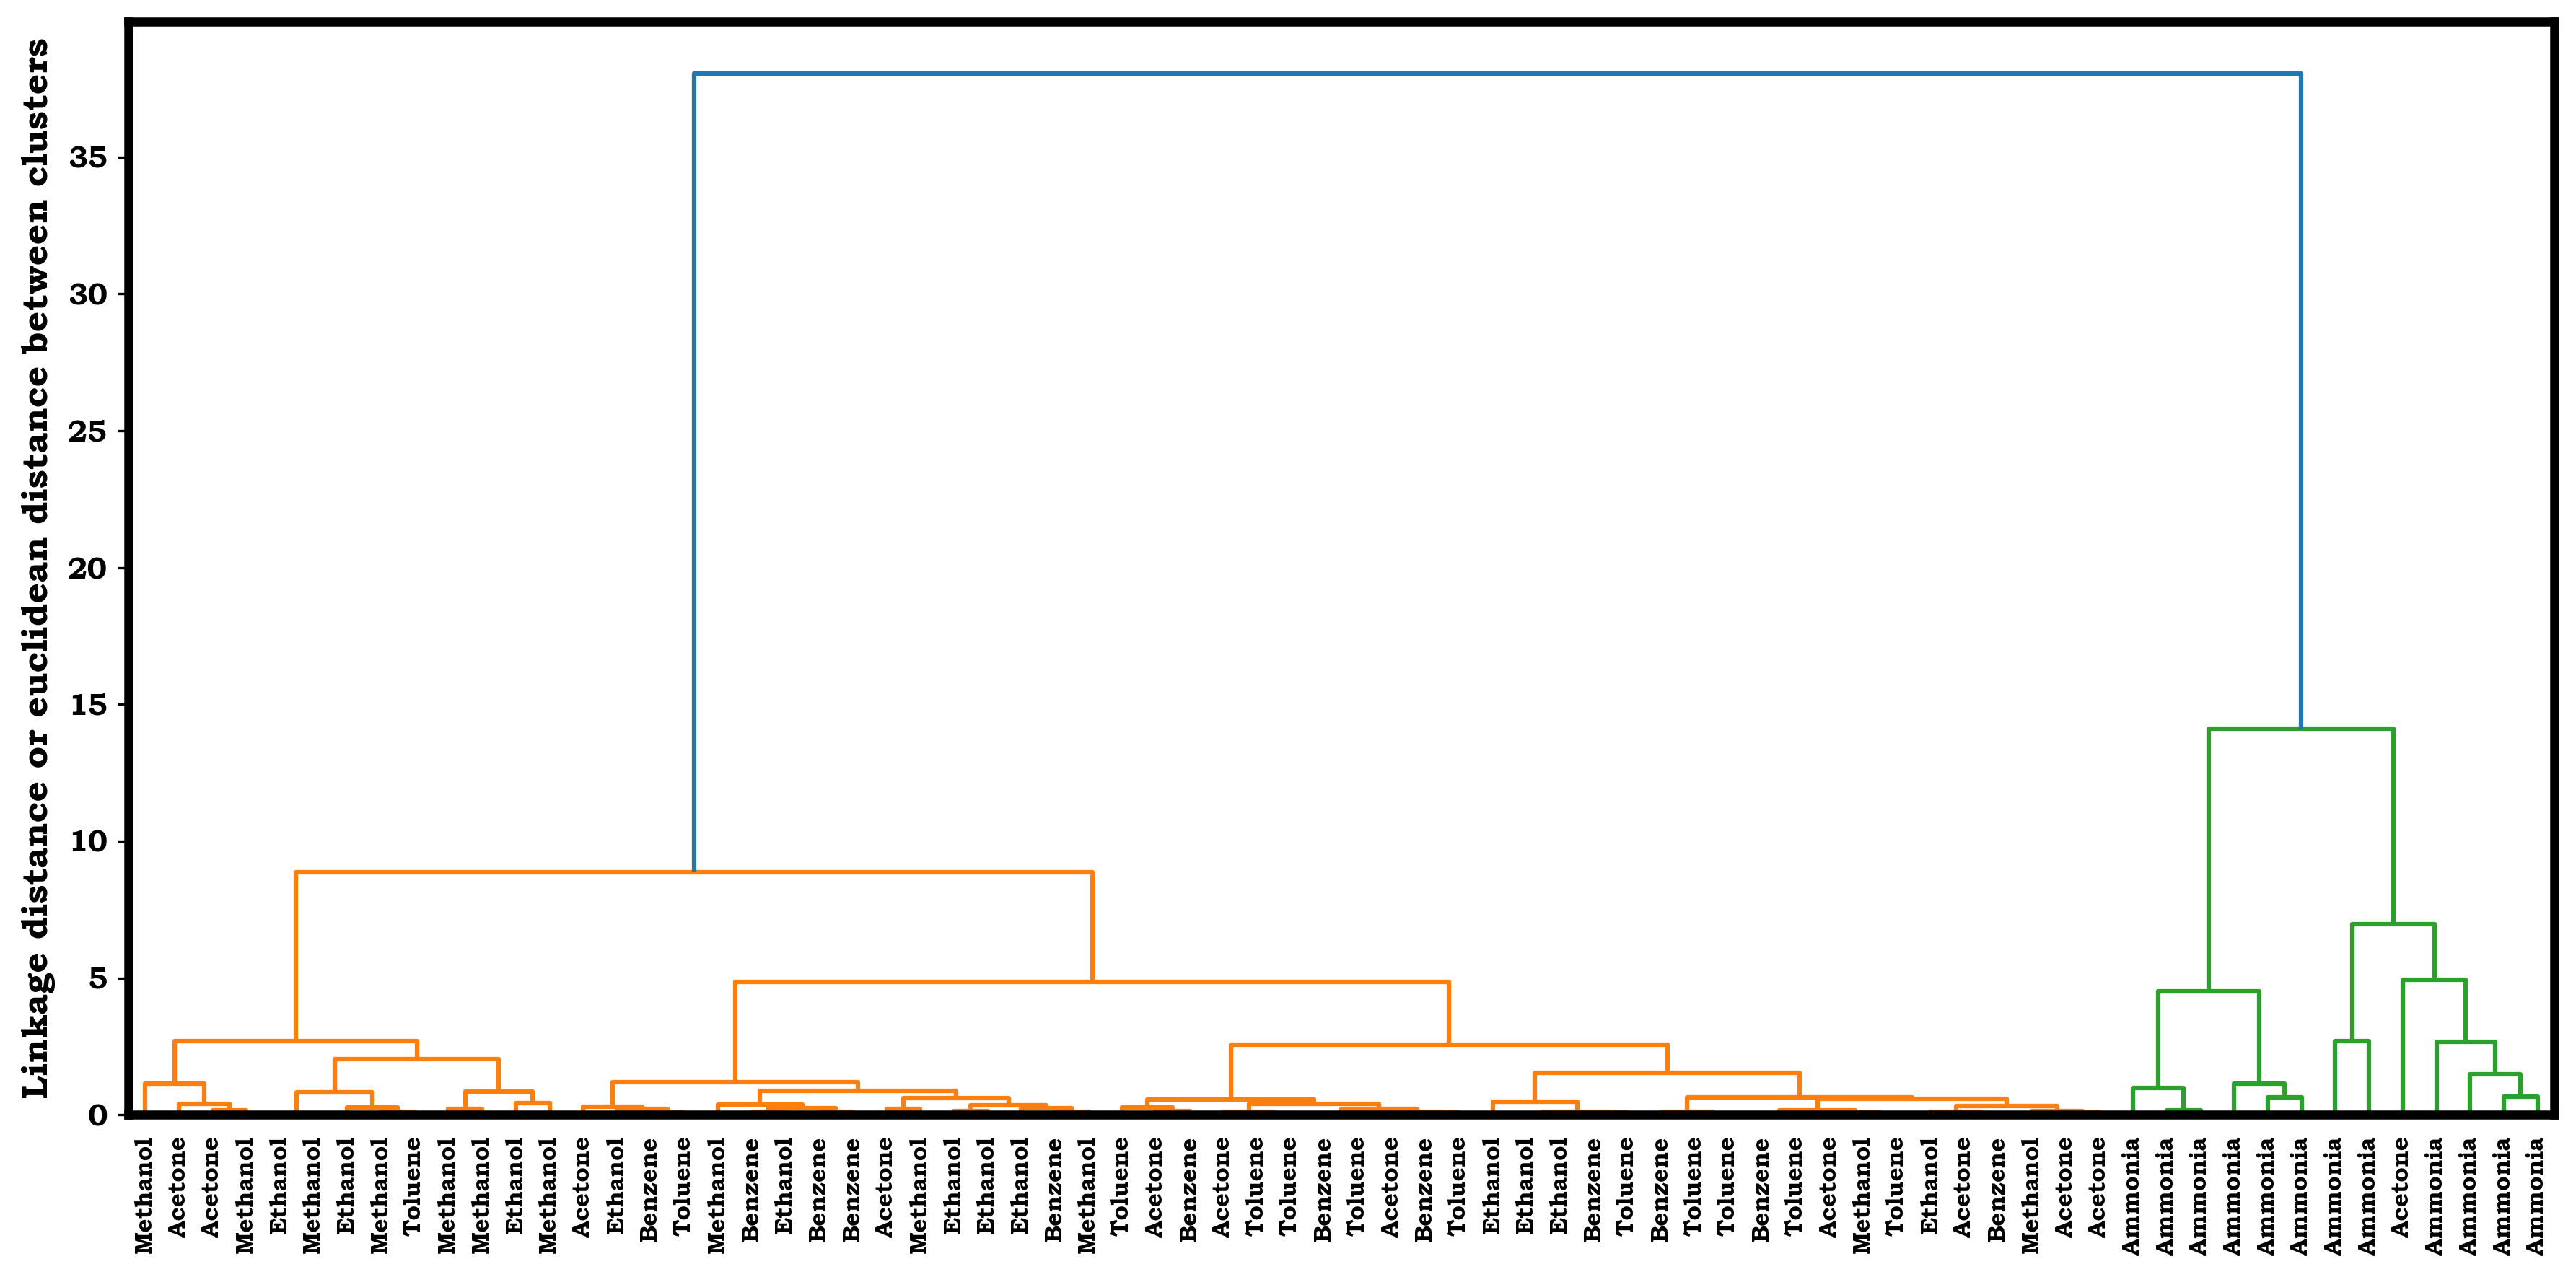

In [18]:
hca_plot(X=CSA_pca, y=y, features=["PC1", "PC3"],
         threshold=15, linkage_method="ward")

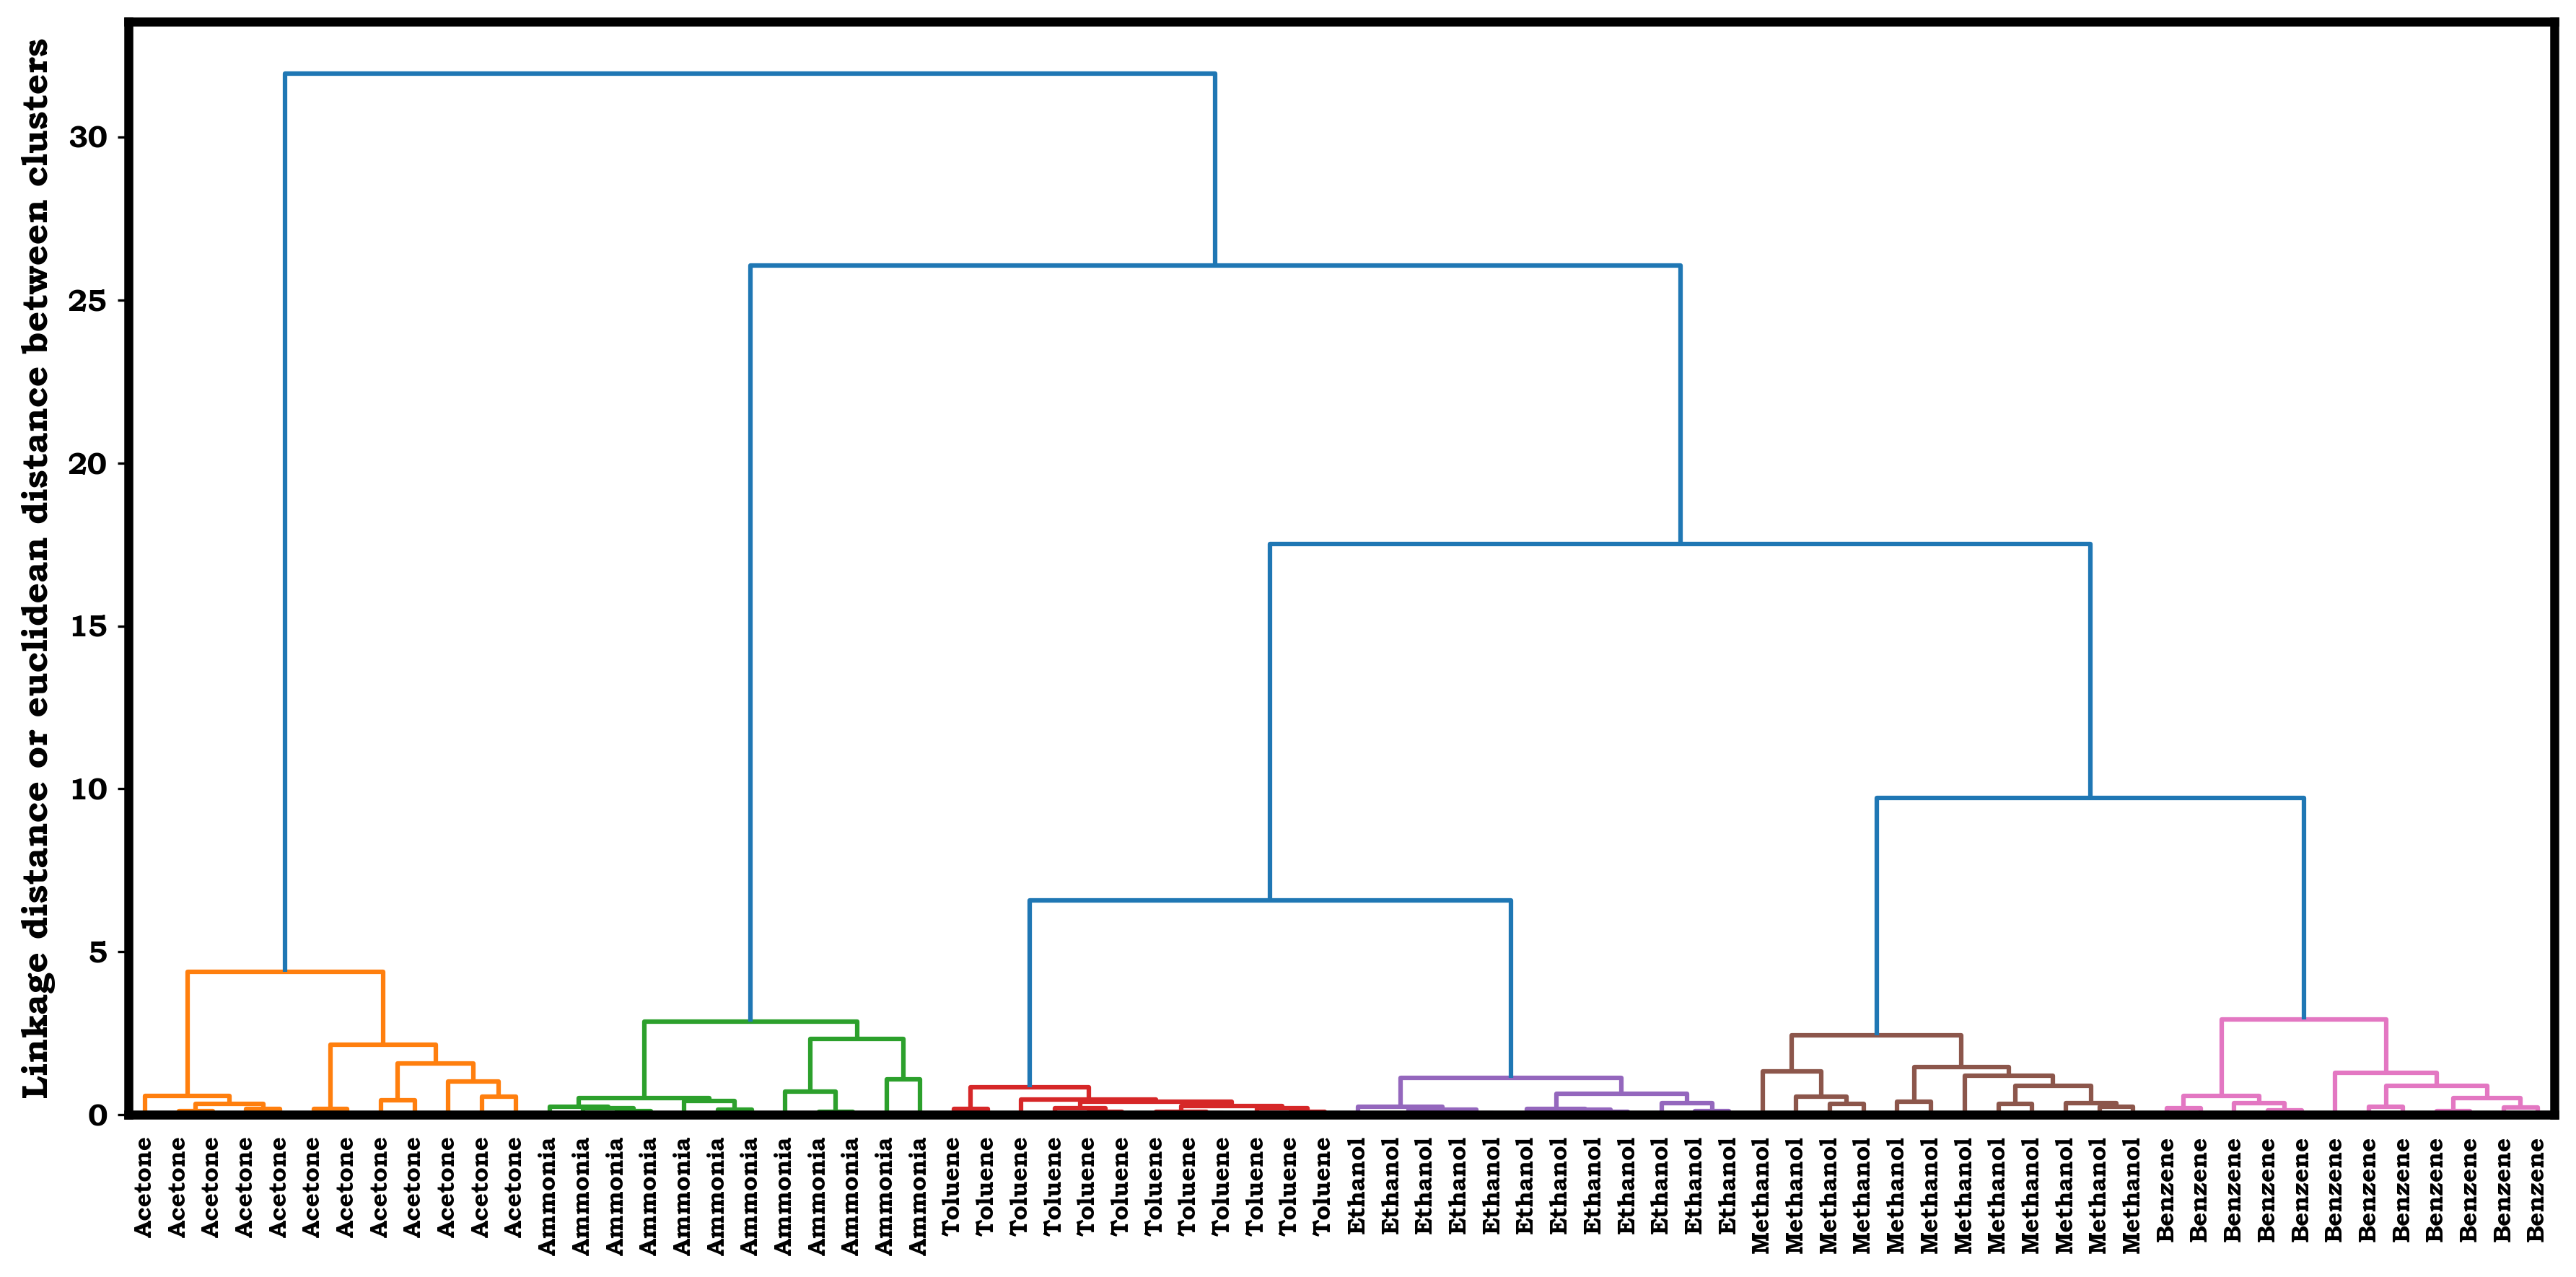

In [19]:
hca_plot(X=hybrid_pca, y=y, features=[
         "PC1", "PC2"], threshold=5, linkage_method="ward")

In [20]:
def scores_of_classifiers(X=None, y=None,
                          test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size,
        random_state=42)
    lda_model = Pipeline(
        steps=[("Scaler", StandardScaler()),
               ("LDA", LinearDiscriminantAnalysis())],
        verbose=False)
    svc_model = Pipeline(
        steps=[("Scaler", StandardScaler()),
               ("SVM", SVC())],
        verbose=False)
    rfc_model = Pipeline(
        steps=[("Scaler", StandardScaler()),
               ("RFC", RandomForestClassifier(random_state=42))],
        verbose=False)
    # Training Phase
    lda_model.fit(X_train, y_train)
    svc_model.fit(X_train, y_train)
    rfc_model.fit(X_train, y_train)
    # Predicting Phase
    y_pred_lda = lda_model.predict(X_test)
    y_pred_svc = svc_model.predict(X_test)
    y_pred_rfc = rfc_model.predict(X_test)
    # Testing Phase
    score_lda = round(f1_score(y_test,
                               y_pred_lda, average="macro"), 3)
    score_svc = round(f1_score(y_test, y_pred_svc,
                               average="macro"), 3)
    score_rfc = round(f1_score(y_test, y_pred_rfc,
                               average="macro"), 3)
    return pd.Series(data=[score_lda, score_svc, score_rfc],
                     index=["LDA", "SVM", "RFC"])

In [21]:
scores = list()
for df in [X_MOS_selected, X_CSA_selected, X_FUSION_selected]:
    scores.append(scores_of_classifiers(df, y, test_size=0.75))
systems = ["Metal Oxide Sensors Only",
           "Colorimetric Sensors Only",
           "Hybrid"]
scores_report = pd.concat(scores, axis=1, keys=systems).T

In [22]:
scores_report

,LDA,SVM,RFC
Metal Oxide Sensors Only,0.883,0.769,0.795
Colorimetric Sensors Only,0.546,0.283,0.388
Hybrid,0.906,1.000,1.000
